In [2]:
import pandas as pd
import numpy as np

import re

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'ner'])
nlp.add_pipe(nlp.create_pipe('sentencizer'))
from spacy.lang.en.stop_words import STOP_WORDS

In [4]:
# gensim
from gensim import corpora, models, similarities, matutils

# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
import scipy.sparse as ss

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import datasets

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
#DF that was created with all speeches info
speeches = pd.read_csv(r'C:\Users\krystynametcalf\Desktop\speeches_para_df.csv', dtype=str)
speeches.head(3)

,Title,Speech,Year
0,"A House of Many Mansions, 1940",Everyone wonders what is happening about the w...,1940
1,"A House of Many Mansions, 1940",But what would happen if all these neutral nat...,1940
2,"A House of Many Mansions, 1940",“Leave the past to history especially as I pro...,1940


In [7]:
speeches.isnull().sum()

Title     0
Speech    0
Year      0
dtype: int64

In [8]:
speeches.dtypes

Title     object
Speech    object
Year      object
dtype: object

In [9]:
speeches['Speech'] = speeches['Speech'].replace({'United States': 'UnitedStates'}, regex=True)

In [10]:
speeches['Year'].unique()

array(['1940 ', '1939 ', '1936 ', '1941 ', '1920 ', '1899 ', '1900 ',
       '1919 ', '1938 ', '1931 ', '1949 ', '1925 ', '1934 ', '1946 ',
       '1944 ', '1945 '], dtype=object)

In [11]:
speeches['Year'] = speeches['Year'].str.strip()

In [12]:
speeches['Year'].unique()

array(['1940', '1939', '1936', '1941', '1920', '1899', '1900', '1919',
       '1938', '1931', '1949', '1925', '1934', '1946', '1944', '1945'],
      dtype=object)

In [13]:
speeches.shape

(406, 3)

## spaCy

In [14]:
len(STOP_WORDS)

326

In [15]:
def get_stopwords():
    "Return a set of stopwords read in from a file."
    f = STOP_WORDS
    stopwords = []
    for line in f:
        stopwords.append(line.strip("\n"))
    # Convert to set for performance
    stopwords_set = set(stopwords)
    return stopwords_set

stopwords = get_stopwords()

In [16]:
inputfile = "data/spacy_multiprocess/nytimes-sample.tsv"
stopwordfile = "data/spacy_multiprocess/stopwords/stopwords.txt"
limit = 0

In [17]:
def cleaner(df):
    "Extract relevant text from DataFrame using a regex"
    # Regex pattern for only alphanumeric, hyphenated text with 3 or more chars
    pattern = re.compile(r"[A-Za-z0-9\-]{3,50}")
    speeches['Clean'] = speeches['Speech'].str.findall(pattern).str.join(' ')
    if limit > 0:
        return df.iloc[:limit, :].copy()
    else:
        return df

In [18]:
speeches_df = cleaner(speeches)
speeches_df.head(3)

,Title,Speech,Year,Clean
0,"A House of Many Mansions, 1940",Everyone wonders what is happening about the w...,1940,Everyone wonders what happening about the war ...
1,"A House of Many Mansions, 1940",But what would happen if all these neutral nat...,1940,But what would happen all these neutral nation...
2,"A House of Many Mansions, 1940",“Leave the past to history especially as I pro...,1940,Leave the past history especially propose writ...


In [19]:
def lemmatize(text):
    """Perform lemmatization and stopword removal in the clean text
       Returns a list of lemmas
    """
    doc = nlp(text)
    lemma_list = [str(tok.lemma_).lower() for tok in doc
                  if tok.is_alpha and tok.text.lower() not in STOP_WORDS]
    return lemma_list

In [20]:
speeches_df['preproc'] = speeches_df['Clean'].apply(lemmatize)
speeches_df.head(3)

,Title,Speech,Year,Clean,preproc
0,"A House of Many Mansions, 1940",Everyone wonders what is happening about the w...,1940,Everyone wonders what happening about the war ...,"[wonder, happen, war, month, past, nazis, utte..."
1,"A House of Many Mansions, 1940",But what would happen if all these neutral nat...,1940,But what would happen all these neutral nation...,"[happen, neutral, nation, mention, mention, sp..."
2,"A House of Many Mansions, 1940",“Leave the past to history especially as I pro...,1940,Leave the past history especially propose writ...,"[leave, past, history, especially, propose, wr..."


In [21]:
speeches_df['preproc'][1]

['happen',
 'neutral',
 'nation',
 'mention',
 'mention',
 'spontaneous',
 'impulse',
 'duty']

In [22]:
def make_string(text):
    return ' '.join(text)
docs = speeches_df['preproc'].apply(make_string)

In [23]:
speeches_df.shape

(406, 5)

## Create dataframes based on Time Series

#### Create Masks for each time period

In [24]:
EY_mask = (speeches_df['Year'] < '1932')  #EY- Early Years

In [25]:
TR_mask = ((speeches_df['Year'] >= '1932') & (speeches_df['Year'] <= '1939')) #TR- Third Reich before WWII

In [26]:
wwII_mask = ((speeches_df['Year'] >= '1939') & (speeches_df['Year'] <= '1946')) #wwII- Second World War

In [27]:
PW_mask = (speeches_df['Year'] > '1946') #PW- Post World War

#### Create Dataframes for each time period
##### Early Years

In [28]:
EY = speeches_df[EY_mask]

##### Third Reich

In [29]:
TR = speeches_df[TR_mask]

##### World War II 

In [30]:
w2 = speeches_df[wwII_mask]

##### Post War 

In [31]:
PW = speeches_df[PW_mask]

#### Check Years in Each Timeframe

In [32]:
EY['Year'].unique()

array(['1920', '1899', '1900', '1919', '1931', '1925'], dtype=object)

In [33]:
TR['Year'].unique()

array(['1939', '1936', '1938', '1934'], dtype=object)

In [34]:
w2['Year'].unique()

array(['1940', '1939', '1941', '1946', '1944', '1945'], dtype=object)

In [35]:
PW['Year'].unique()

array(['1949'], dtype=object)

#### Check Number of Speeches in Each Time Series

In [36]:
EY.shape

(51, 5)

In [37]:
TR.shape

(77, 5)

In [38]:
w2.shape

(228, 5)

In [39]:
PW.shape

(56, 5)

## Early Years LDA

In [40]:
def make_string(text):
    return ' '.join(text)
EY['preproc']= EY['preproc'].apply(make_string)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")

count_vectorizer.fit(EY.preproc)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
                tokenizer=None, vocabulary=None)

In [45]:
# Create the term-document matrix
# Transpose it so the terms are the rows
EYdoc_word = count_vectorizer.transform(EY.preproc).transpose()

In [47]:
import pandas as pd

pd.DataFrame(EYdoc_word.toarray(), count_vectorizer.get_feature_names()).head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
abe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abe bailey,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ability,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ability feel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
able,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
EYdoc_word.shape

(6386, 51)

In [49]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(EYdoc_word)

In [50]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [51]:
len(id2word)

6386

In [52]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=5)

2020-09-15 15:58:01,977 : INFO : using symmetric alpha at 0.3333333333333333
2020-09-15 15:58:01,979 : INFO : using symmetric eta at 0.3333333333333333
2020-09-15 15:58:01,981 : INFO : using serial LDA version on this node
2020-09-15 15:58:01,984 : INFO : running online (multi-pass) LDA training, 3 topics, 5 passes over the supplied corpus of 51 documents, updating model once every 51 documents, evaluating perplexity every 51 documents, iterating 50x with a convergence threshold of 0.001000
2020-09-15 15:58:01,984 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-09-15 15:58:02,134 : INFO : -10.131 per-word bound, 1121.3 perplexity estimate based on a held-out corpus of 51 documents with 8873 words
2020-09-15 15:58:02,134 : INFO : PROGRESS: pass 0, at document #51/51
2020-09-15 15:58:02,192 : INFO : topic #0 (0.333): 0.003*"man" + 0.003*"great" + 0.002*"world" + 0.002*"time" + 0.002*"mass" + 0.002*"

In [53]:
lda.print_topics()

2020-09-15 15:58:05,158 : INFO : topic #0 (0.333): 0.002*"war" + 0.002*"mass" + 0.002*"long" + 0.002*"russia" + 0.002*"gas" + 0.002*"great" + 0.002*"man" + 0.001*"public" + 0.001*"think" + 0.001*"wells"
2020-09-15 15:58:05,159 : INFO : topic #1 (0.333): 0.005*"churchill" + 0.005*"winston" + 0.004*"winston churchill" + 0.004*"history" + 0.003*"man" + 0.002*"work" + 0.002*"propose" + 0.002*"time" + 0.002*"leader" + 0.002*"past"
2020-09-15 15:58:05,160 : INFO : topic #2 (0.333): 0.005*"man" + 0.004*"great" + 0.003*"power" + 0.003*"world" + 0.003*"time" + 0.003*"year" + 0.002*"human" + 0.002*"live" + 0.002*"know" + 0.002*"present"


[(0,
  '0.002*"war" + 0.002*"mass" + 0.002*"long" + 0.002*"russia" + 0.002*"gas" + 0.002*"great" + 0.002*"man" + 0.001*"public" + 0.001*"think" + 0.001*"wells"'),
 (1,
  '0.005*"churchill" + 0.005*"winston" + 0.004*"winston churchill" + 0.004*"history" + 0.003*"man" + 0.002*"work" + 0.002*"propose" + 0.002*"time" + 0.002*"leader" + 0.002*"past"'),
 (2,
  '0.005*"man" + 0.004*"great" + 0.003*"power" + 0.003*"world" + 0.003*"time" + 0.003*"year" + 0.002*"human" + 0.002*"live" + 0.002*"know" + 0.002*"present"')]

#### Add Stop Words

In [54]:
from gensim.parsing.preprocessing import STOPWORDS
my_stop_words = STOPWORDS.union(set(['war', 'man', 'great', 'winston', 'churchill', 'world', 'time', 'past']))

In [55]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words=my_stop_words, token_pattern="\\b[a-z][a-z]+\\b")

count_vectorizer.fit(EY.preproc)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
                tokenizer=None, vocabulary=None)

In [56]:
doc_word = count_vectorizer.transform(EY.preproc).transpose()

In [57]:
pd.DataFrame(doc_word.toarray(), count_vectorizer.get_feature_names()).head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
abe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abe bailey,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ability,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ability feel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
able,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word)

In [59]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [60]:
len(id2word)

6188

In [61]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=5)

2020-09-15 15:58:13,286 : INFO : using symmetric alpha at 0.3333333333333333
2020-09-15 15:58:13,287 : INFO : using symmetric eta at 0.3333333333333333
2020-09-15 15:58:13,289 : INFO : using serial LDA version on this node
2020-09-15 15:58:13,292 : INFO : running online (multi-pass) LDA training, 3 topics, 5 passes over the supplied corpus of 51 documents, updating model once every 51 documents, evaluating perplexity every 51 documents, iterating 50x with a convergence threshold of 0.001000
2020-09-15 15:58:13,292 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-09-15 15:58:13,401 : INFO : -10.126 per-word bound, 1117.8 perplexity estimate based on a held-out corpus of 51 documents with 8386 words
2020-09-15 15:58:13,402 : INFO : PROGRESS: pass 0, at document #51/51
2020-09-15 15:58:13,466 : INFO : topic #0 (0.333): 0.003*"history" + 0.002*"write" + 0.002*"power" + 0.002*"year" + 0.002*"propose" + 

In [62]:
lda.print_topics()

2020-09-15 15:58:15,632 : INFO : topic #0 (0.333): 0.004*"history" + 0.002*"work" + 0.002*"propose" + 0.002*"long" + 0.002*"write" + 0.002*"year" + 0.002*"live" + 0.002*"form" + 0.002*"thousand" + 0.002*"far"
2020-09-15 15:58:15,633 : INFO : topic #1 (0.333): 0.003*"power" + 0.002*"know" + 0.002*"human" + 0.002*"year" + 0.002*"live" + 0.002*"future" + 0.002*"energy" + 0.002*"new" + 0.002*"life" + 0.001*"produce"
2020-09-15 15:58:15,635 : INFO : topic #2 (0.333): 0.002*"mass" + 0.002*"gas" + 0.002*"russia" + 0.002*"leader" + 0.001*"nation" + 0.001*"look" + 0.001*"effect" + 0.001*"think" + 0.001*"know" + 0.001*"year"


[(0,
  '0.004*"history" + 0.002*"work" + 0.002*"propose" + 0.002*"long" + 0.002*"write" + 0.002*"year" + 0.002*"live" + 0.002*"form" + 0.002*"thousand" + 0.002*"far"'),
 (1,
  '0.003*"power" + 0.002*"know" + 0.002*"human" + 0.002*"year" + 0.002*"live" + 0.002*"future" + 0.002*"energy" + 0.002*"new" + 0.002*"life" + 0.001*"produce"'),
 (2,
  '0.002*"mass" + 0.002*"gas" + 0.002*"russia" + 0.002*"leader" + 0.001*"nation" + 0.001*"look" + 0.001*"effect" + 0.001*"think" + 0.001*"know" + 0.001*"year"')]

In [63]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(lda[corpus]):
        row = row_list[0] if lda.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.sort_values('Topic_Perc_Contrib')
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9900,"power, know, human, year, live, future, energy...",wonder happen war month past nazis utter feroc...
1,1,1.0,0.9943,"power, know, human, year, live, future, energy...",happen neutral nation mention mention spontane...
2,2,1.0,0.9736,"power, know, human, year, live, future, energy...",leave past history especially propose write hi...
3,3,1.0,0.9856,"power, know, human, year, live, future, energy...",aggrieve belligerent powers wage war germany n...
4,4,2.0,0.9784,"mass, gas, russia, leader, nation, look, effec...",magnetic mine narrow water approach island str...
5,5,0.0,0.9926,"history, work, propose, long, write, year, liv...",accordance covenant league stand british frenc...
6,6,2.0,0.9893,"mass, gas, russia, leader, nation, look, effec...",different lot unfortunate neutral sea land vic...
7,7,2.0,0.9918,"mass, gas, russia, leader, nation, look, effec...",nearly month sea u boat campaign time utterly ...
8,8,2.0,0.9939,"mass, gas, russia, leader, nation, look, effec...",bitter increasingly exact conflict lie resolve...
9,9,1.0,0.9904,"power, know, human, year, live, future, energy...",thing helpful determine action neutral increas...


In [64]:
speeches_df[speeches_df['Speech'].str.contains("form")]
                                               

,Title,Speech,Year,Clean,preproc
12,"A Hush Over Europe, 1939","There is a hush over all Europe, nay, over all...",1939,There hush over all Europe nay over all the wo...,"[hush, europe, nay, world, break, dull, thud, ..."
18,"Abdication of King Edward VIII, 1936",Nothing is more certain or more obvious than t...,1936,Nothing more certain more obvious than that re...,"[certain, obvious, recrimination, controversy,..."
20,"Address to Joint Session of US Congress, 1941",We have indeed to be thankful that so much tim...,1941,have indeed thankful that much time has been g...,"[thankful, time, grant, germany, try, invade, ..."
34,"Address to Joint Session of US Congress, 1941",For the best part of twenty years the youth of...,1941,For the best part twenty years the youth Brita...,"[well, year, youth, britain, america, teach, w..."
54,Be Ye Men of Valour,I speak to you for the first time as Prime Min...,1940,speak you for the first time Prime Minister so...,"[speak, time, prime, minister, solemn, hour, l..."
...,...,...,...,...,...
394,"We Shall Fight on the Beaches, 1940",Every morn brought forth a noble chanceAnd eve...,1940,Every morn brought forth noble chanceAnd every...,"[morn, bring, forth, noble, chanceand, chance,..."
395,"We Shall Fight on the Beaches, 1940",From the moment that the French defences at Se...,1940,From the moment that the French defences Sedan...,"[moment, french, defence, sedan, meuse, break,..."
396,Winston Churchill announces the Surrender of G...,German armed forces surrendered unconditionall...,1945,German armed forces surrendered unconditionall...,"[german, arm, force, surrender, unconditionall..."
399,"Winston Churchill to Franklin D. Roosevelt, 1940",I have now decided to ask for your formal agré...,1940,have now decided ask for your formal agr ment ...,"[decide, ask, formal, agr, ment, appointment, ..."


In [65]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9993,"history, work, propose, long, write, year, live, form, thousand, far",washington memorable day find olympian fortitude far base complacency mask inflexible purpose pr...
1,1.0,0.9997,"power, know, human, year, live, future, energy, new, life, produce",lastly forgive say well tidings unitedstates unite draw sword freedom cast away scabbard
2,2.0,0.9972,"mass, gas, russia, leader, nation, look, effect, think, know, year",people astonish japan single day plunge war unitedstates british empire wonder dark design labor...


In [66]:
df_dominant_topic.to_csv(r'C:\Users\krystynametcalf\Desktop\EYdf.csv', index=False) 

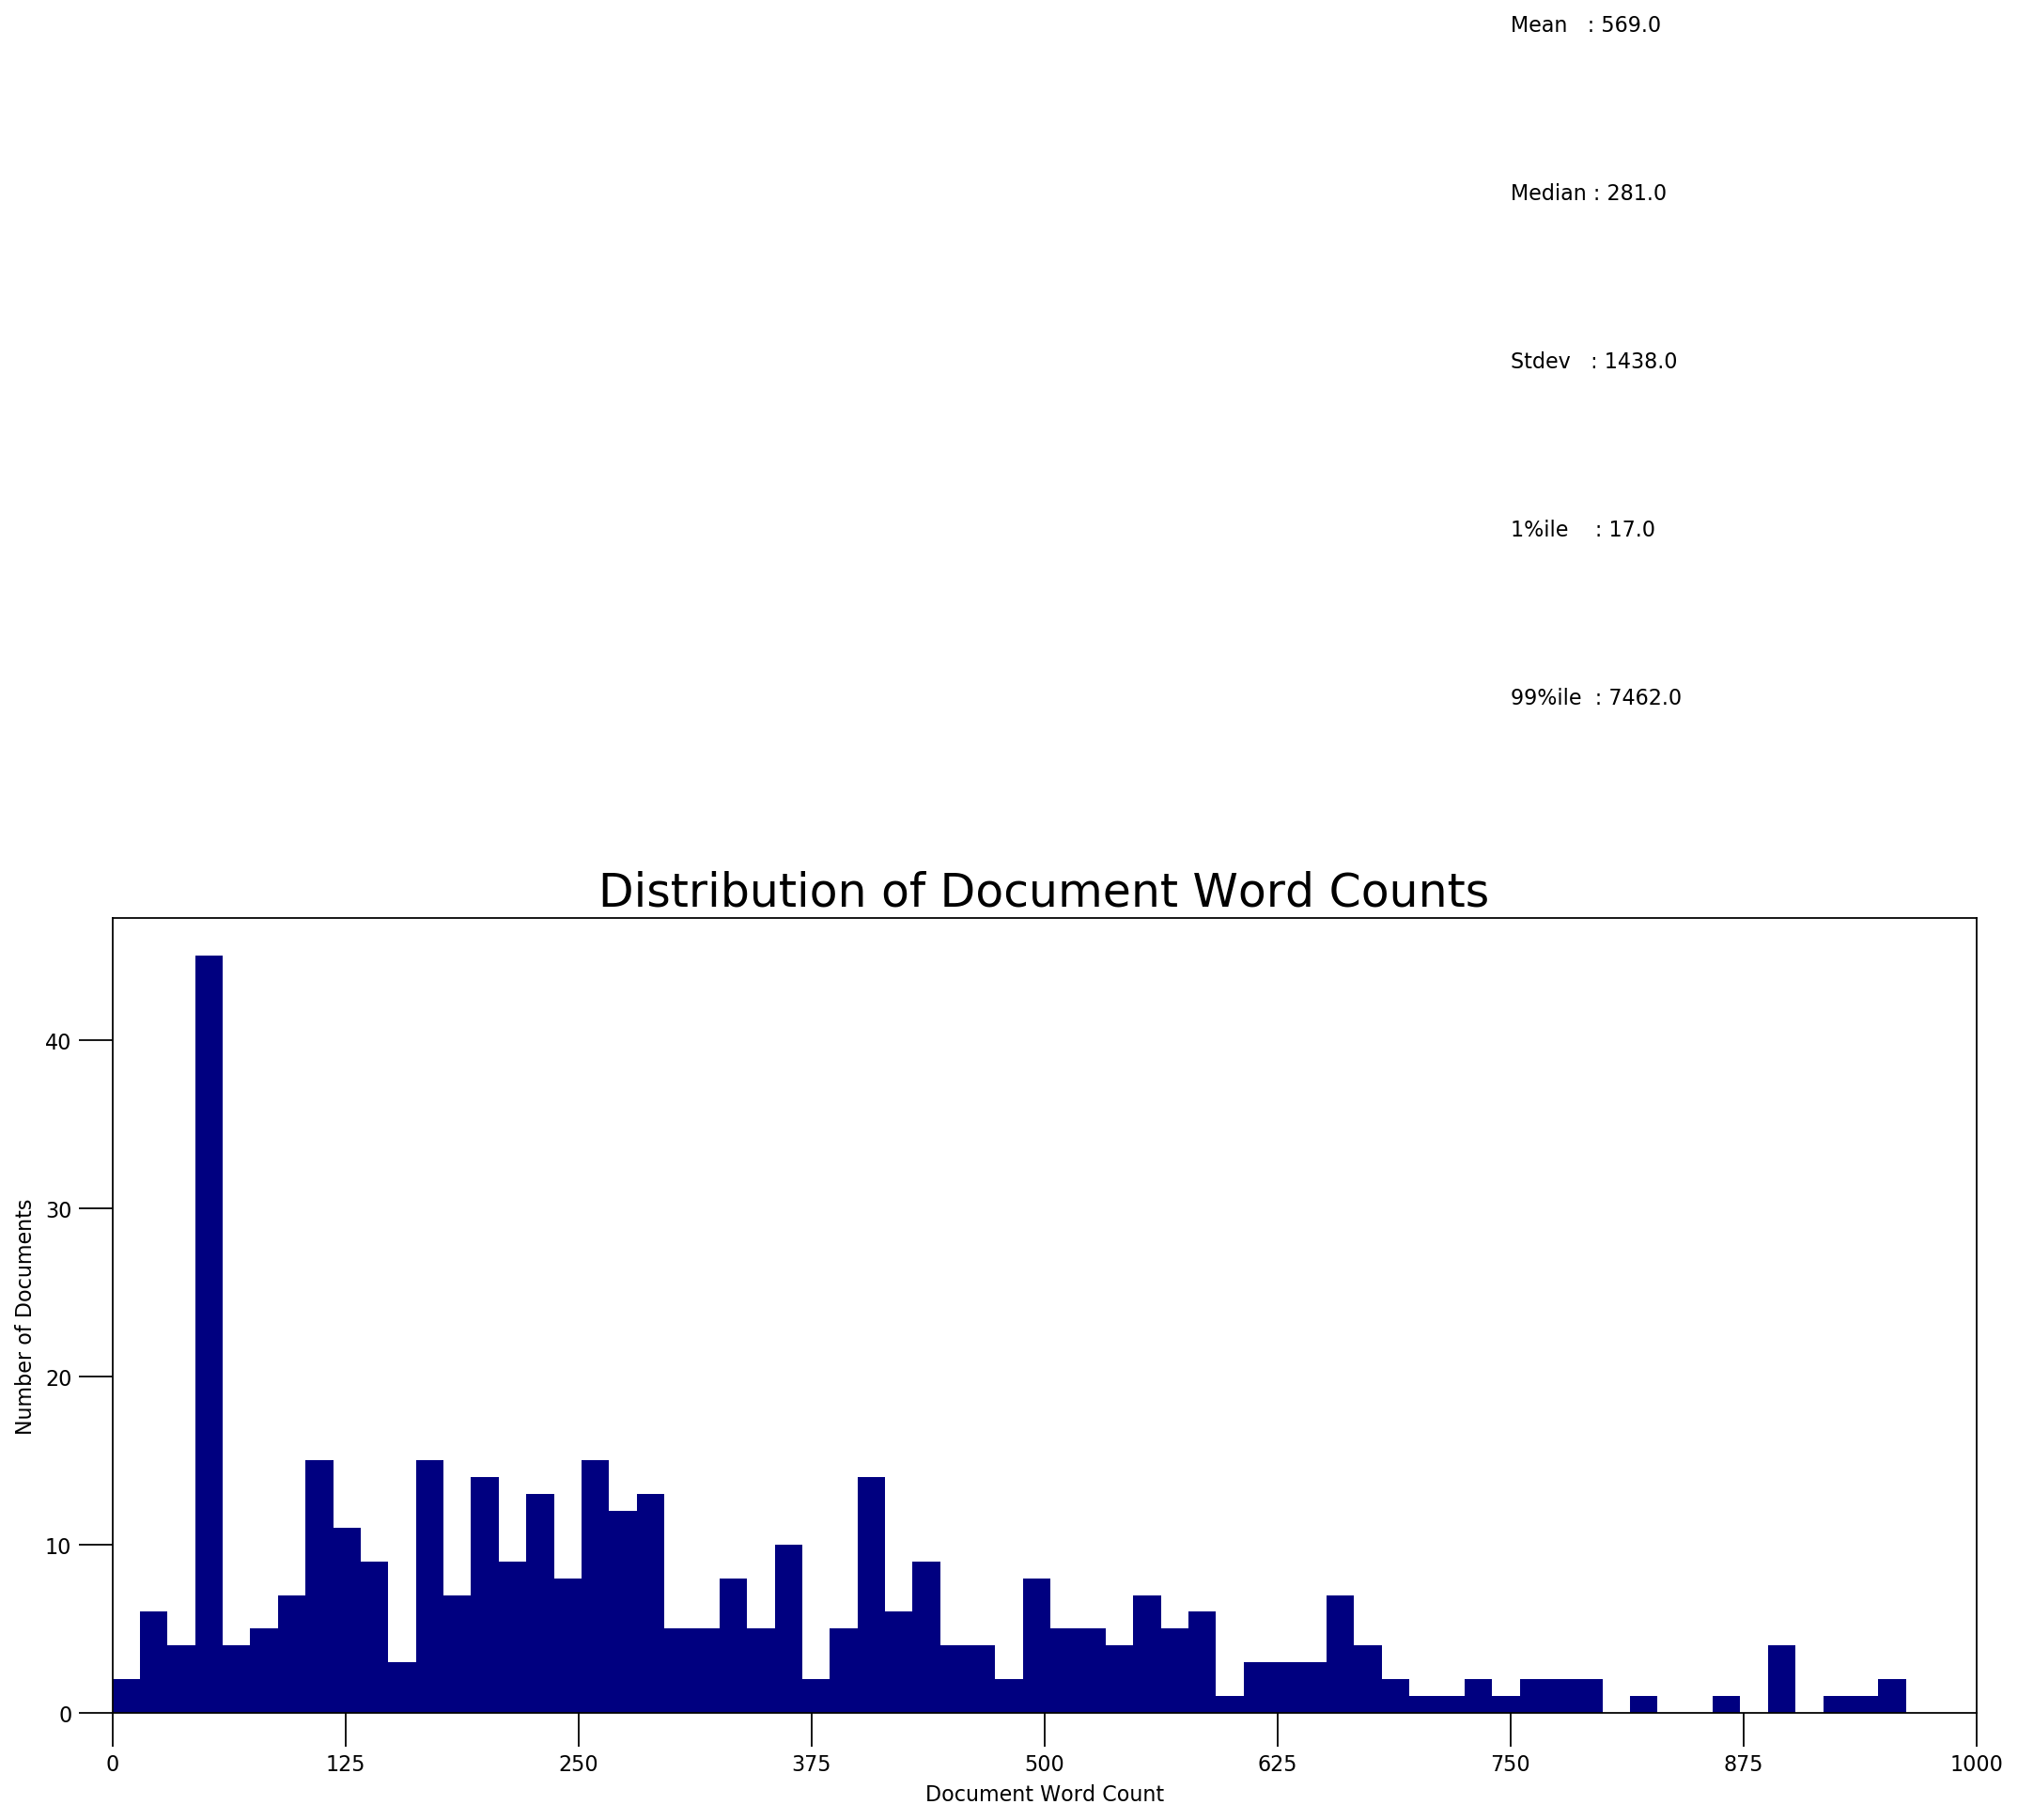

In [268]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

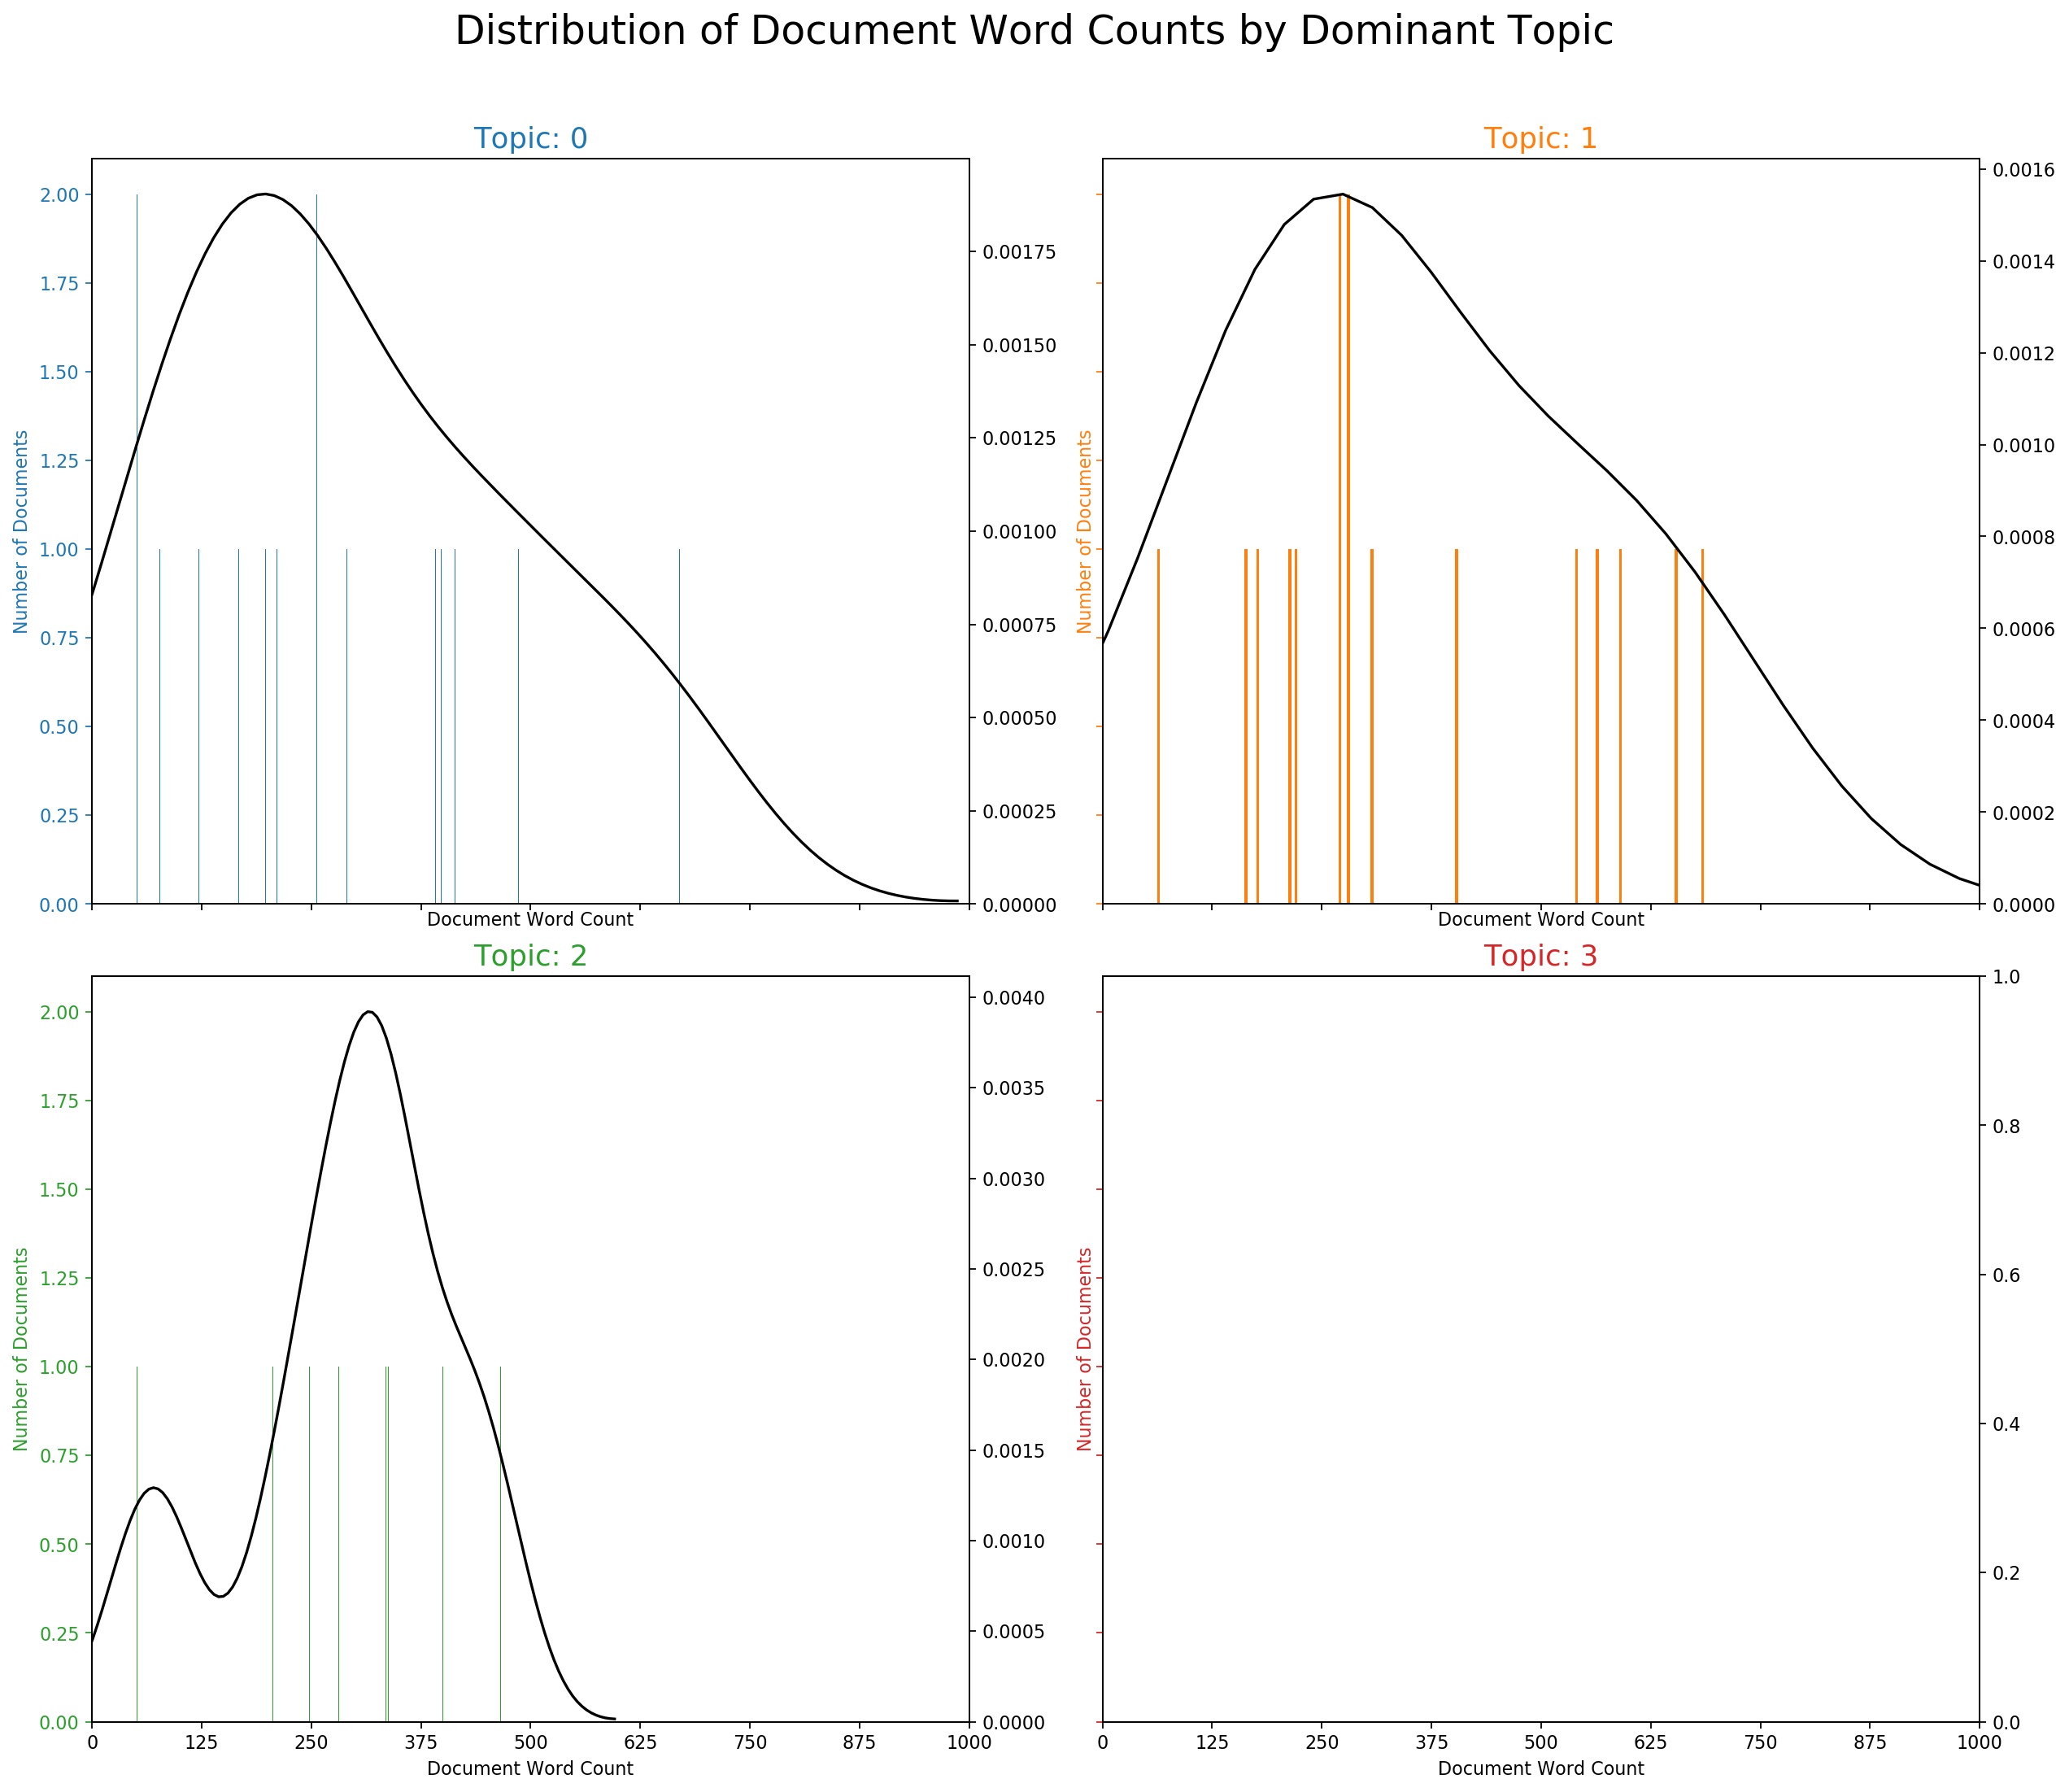

In [269]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

IndexError: list index out of range

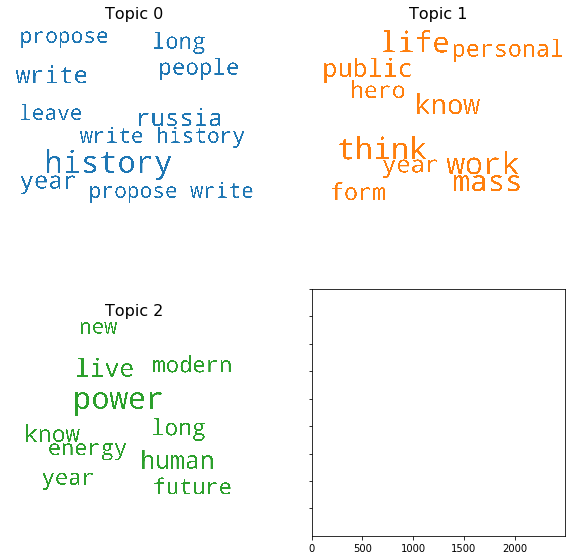

In [270]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()   

## Third Reich LDA

In [67]:
def make_string(text):
    return ' '.join(text)
TR['preproc']= TR['preproc'].apply(make_string)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [68]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")

count_vectorizer.fit(TR.preproc)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
                tokenizer=None, vocabulary=None)

In [69]:
# Create the term-document matrix
# Transpose it so the terms are the rows
doc_word = count_vectorizer.transform(TR.preproc).transpose()

In [70]:
import pandas as pd

pd.DataFrame(doc_word.toarray(), count_vectorizer.get_feature_names()).head()

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
abandonment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
abandonment ruin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
abash,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
abash distract,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
abide,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word)

In [72]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [73]:
len(id2word)

6590

In [74]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=5)

2020-09-15 16:00:40,618 : INFO : using symmetric alpha at 0.3333333333333333
2020-09-15 16:00:40,619 : INFO : using symmetric eta at 0.3333333333333333
2020-09-15 16:00:40,621 : INFO : using serial LDA version on this node
2020-09-15 16:00:40,624 : INFO : running online (multi-pass) LDA training, 3 topics, 5 passes over the supplied corpus of 77 documents, updating model once every 77 documents, evaluating perplexity every 77 documents, iterating 50x with a convergence threshold of 0.001000
2020-09-15 16:00:40,625 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-09-15 16:00:40,789 : INFO : -10.104 per-word bound, 1100.7 perplexity estimate based on a held-out corpus of 77 documents with 9911 words
2020-09-15 16:00:40,790 : INFO : PROGRESS: pass 0, at document #77/77
2020-09-15 16:00:40,876 : INFO : topic #0 (0.333): 0.003*"war" + 0.003*"great" + 0.002*"country" + 0.002*"year" + 0.002*"power" + 0.00

In [75]:
lda.print_topics()

2020-09-15 16:00:42,634 : INFO : topic #0 (0.333): 0.003*"year" + 0.002*"war" + 0.002*"power" + 0.002*"great" + 0.002*"time" + 0.002*"position" + 0.002*"country" + 0.002*"know" + 0.002*"france" + 0.002*"czechoslovakia"
2020-09-15 16:00:42,636 : INFO : topic #1 (0.333): 0.004*"man" + 0.003*"great" + 0.003*"war" + 0.002*"time" + 0.002*"day" + 0.002*"force" + 0.002*"german" + 0.002*"country" + 0.002*"power" + 0.002*"right"
2020-09-15 16:00:42,637 : INFO : topic #2 (0.333): 0.003*"war" + 0.003*"people" + 0.003*"great" + 0.003*"power" + 0.003*"man" + 0.002*"time" + 0.002*"history" + 0.002*"world" + 0.002*"far" + 0.002*"government"


[(0,
  '0.003*"year" + 0.002*"war" + 0.002*"power" + 0.002*"great" + 0.002*"time" + 0.002*"position" + 0.002*"country" + 0.002*"know" + 0.002*"france" + 0.002*"czechoslovakia"'),
 (1,
  '0.004*"man" + 0.003*"great" + 0.003*"war" + 0.002*"time" + 0.002*"day" + 0.002*"force" + 0.002*"german" + 0.002*"country" + 0.002*"power" + 0.002*"right"'),
 (2,
  '0.003*"war" + 0.003*"people" + 0.003*"great" + 0.003*"power" + 0.003*"man" + 0.002*"time" + 0.002*"history" + 0.002*"world" + 0.002*"far" + 0.002*"government"')]

### Stop Words

In [76]:
my_stop_words = STOPWORDS.union(set(['war', 'man', 'great', 'power', 'german', 'prime', 'minister']))

In [77]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words=my_stop_words, token_pattern="\\b[a-z][a-z]+\\b")

count_vectorizer.fit(TR.preproc)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
                tokenizer=None, vocabulary=None)

In [78]:
# Create the term-document matrix
# Transpose it so the terms are the rows
doc_word = count_vectorizer.transform(TR.preproc).transpose()

In [79]:
import pandas as pd

pd.DataFrame(doc_word.toarray(), count_vectorizer.get_feature_names()).head()

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
abandonment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
abandonment ruin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
abash,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
abash distract,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
abide,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word)

In [81]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [82]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=5)

2020-09-15 16:00:48,327 : INFO : using symmetric alpha at 0.3333333333333333
2020-09-15 16:00:48,328 : INFO : using symmetric eta at 0.3333333333333333
2020-09-15 16:00:48,330 : INFO : using serial LDA version on this node
2020-09-15 16:00:48,333 : INFO : running online (multi-pass) LDA training, 3 topics, 5 passes over the supplied corpus of 77 documents, updating model once every 77 documents, evaluating perplexity every 77 documents, iterating 50x with a convergence threshold of 0.001000
2020-09-15 16:00:48,334 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-09-15 16:00:48,516 : INFO : -10.089 per-word bound, 1089.4 perplexity estimate based on a held-out corpus of 77 documents with 9403 words
2020-09-15 16:00:48,517 : INFO : PROGRESS: pass 0, at document #77/77
2020-09-15 16:00:48,609 : INFO : topic #0 (0.333): 0.003*"history" + 0.003*"time" + 0.002*"think" + 0.002*"leave" + 0.002*"write" + 0.

In [83]:
lda.print_topics()

2020-09-15 16:00:50,369 : INFO : topic #0 (0.333): 0.004*"history" + 0.003*"individual" + 0.002*"write" + 0.002*"machine" + 0.002*"leave" + 0.002*"past" + 0.002*"especially" + 0.002*"past history" + 0.002*"propose write" + 0.002*"leave past"
2020-09-15 16:00:50,371 : INFO : topic #1 (0.333): 0.003*"people" + 0.003*"year" + 0.003*"time" + 0.003*"peace" + 0.002*"france" + 0.002*"world" + 0.002*"force" + 0.002*"british" + 0.002*"government" + 0.002*"germany"
2020-09-15 16:00:50,373 : INFO : topic #2 (0.333): 0.003*"country" + 0.003*"time" + 0.002*"know" + 0.002*"force" + 0.002*"far" + 0.002*"day" + 0.002*"germany" + 0.001*"fact" + 0.001*"france" + 0.001*"come"


[(0,
  '0.004*"history" + 0.003*"individual" + 0.002*"write" + 0.002*"machine" + 0.002*"leave" + 0.002*"past" + 0.002*"especially" + 0.002*"past history" + 0.002*"propose write" + 0.002*"leave past"'),
 (1,
  '0.003*"people" + 0.003*"year" + 0.003*"time" + 0.003*"peace" + 0.002*"france" + 0.002*"world" + 0.002*"force" + 0.002*"british" + 0.002*"government" + 0.002*"germany"'),
 (2,
  '0.003*"country" + 0.003*"time" + 0.002*"know" + 0.002*"force" + 0.002*"far" + 0.002*"day" + 0.002*"germany" + 0.001*"fact" + 0.001*"france" + 0.001*"come"')]

In [84]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(lda[corpus]):
        row = row_list[0] if lda.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.sort_values('Topic_Perc_Contrib')
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9992,"people, year, time, peace, france, world, force, british, government, germany",wonder happen war month past nazis utter ferocious threat go western democracies british french ...
1,1,0.0,0.9518,"history, individual, write, machine, leave, past, especially, past history, propose write, leave...",happen neutral nation mention mention spontaneous impulse duty
2,2,0.0,0.9518,"history, individual, write, machine, leave, past, especially, past history, propose write, leave...",leave past history especially propose write history
3,3,1.0,0.9945,"people, year, time, peace, france, world, force, british, government, germany",aggrieve belligerent powers wage war germany need ask respite week commerce grow month organizat...
4,4,1.0,0.9961,"people, year, time, peace, france, world, force, british, government, germany",magnetic mine narrow water approach island strew present problem deem insoluble remember war suf...
5,5,1.0,0.9903,"people, year, time, peace, france, world, force, british, government, germany",accordance covenant league stand british french empires aggression wrong present plight lamentab...
6,6,2.0,0.9948,"country, time, know, force, far, day, germany, fact, france, come",different lot unfortunate neutral sea land victim hitler hate spite descend look group small anc...
7,7,2.0,0.9914,"country, time, know, force, far, day, germany, fact, france, come",nearly month sea u boat campaign time utterly break mine menace good control ship virtually undi...
8,8,2.0,0.9753,"country, time, know, force, far, day, germany, fact, france, come",bitter increasingly exact conflict lie resolve outstrip service common cause let great city wars...
9,9,0.0,0.9518,"history, individual, write, machine, leave, past, especially, past history, propose write, leave...",thing helpful determine action neutral increase sense power resolution western allies small stat...


In [85]:
speeches_df[speeches_df['Speech'].str.contains("Czechoslovakia")]


,Title,Speech,Year,Clean,preproc
87,"Disaster of the First Magnitude, 1938","... I do not think it is fair to charge those who wished to see this course followed, and follow...",1938,not think fair charge those who wished see this course followed and followed consistently and re...,"[think, fair, charge, wish, course, follow, follow, consistently, resolutely, hav, ing, wish, im..."
90,"Disaster of the First Magnitude, 1938",All is over... Czechoslovakia recedes into the dark-ness. She has suffered in every respect by h...,1938,All over Czechoslovakia recedes into the dark-ness She has suffered every respect her associatio...,"[czechoslovakia, recede, dark, ness, suffer, respect, association, western, democracy, league, n..."
95,"Disaster of the First Magnitude, 1938","If the Nazi dictator should choose to look westward, as he may, bitterly will France and England...",1938,the Nazi dictator should choose look westward may bitterly will France and England regret the lo...,"[nazi, dictator, choose, look, westward, bitterly, france, england, regret, loss, fine, army, an..."
96,"Disaster of the First Magnitude, 1938",I venture to think that in the future Czechoslovakian state cannot be maintained as an inde-pend...,1938,venture think that the future Czechoslovakian state cannot maintained inde-pendent entity You wi...,"[venture, think, future, czechoslovakian, state, maintain, inde, pendent, entity, find, period, ..."
97,"Disaster of the First Magnitude, 1938","...Many people, no doubt, honestly believe that they are only giving away the interests of Czech...",1938,Many people doubt honestly believe that they are only giving away the interests Czechoslovakia w...,"[people, doubt, honestly, believe, give, away, interest, czechoslovakia, fear, shall, find, deep..."
99,"Disaster of the First Magnitude, 1938","What is the remaining position of Czechoslovakia-? Not only are they politically muti-lated, but...",1938,What the remaining position Czechoslovakia- Not only are they politically muti-lated but economi...,"[remain, position, politically, muti, lated, economically, financially, complete, confusion, ban..."
101,"Disaster of the First Magnitude, 1938",I have always held the view that the maintenance of peace depends upon the accu-mulation of dete...,1938,have always held the view that the maintenance peace depends upon the accu-mulation deterrents a...,"[hold, view, maintenance, peace, depend, accu, mulation, deterrent, aggressor, couple, sincere, ..."
136,"I Have Watched This Famous Island..., 1938",Then we come to the case of Czechoslovakia. There has been a lot of talk about giving a guarante...,1938,Then come the case Czechoslovakia There has been lot talk about giving guarantee but should sorr...,"[come, case, czechoslovakia, lot, talk, give, guarantee, sorry, grave, issue, open, europe, turn..."
137,"I Have Watched This Famous Island..., 1938",Do not let anyone suppose that this is a mere question of hardening one's heart and keeping a st...,1938,not let anyone suppose that this mere question hardening one heart and keeping stiff upper lip a...,"[let, suppose, mere, question, harden, heart, keep, stiff, upper, lip, stand, czechoslovakia, po..."
144,"I Have Watched This Famous Island..., 1938",I ask these questions hoping that they may be carefully considered. Is it not possible that deci...,1938,ask these questions hoping that they may carefully considered not possible that decided action F...,"[ask, question, hope, carefully, consider, possible, decide, action, france, great, britain, ral..."


In [86]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9960,"history, individual, write, machine, leave, past, especially, past history, propose write, leave...",know year past policy japan dominate secret society subaltern junior officer army navy enforce s...
1,1.0,0.9996,"people, year, time, peace, france, world, force, british, government, germany",think trade union review position carefully year preserve great beneficent influence exercise lo...
2,2.0,0.9976,"country, time, know, force, far, day, germany, fact, france, come",keep war take common measure safety renewal curse need fall owe child torment mankind sure catas...


In [87]:
df_dominant_topic.to_csv(r'C:\Users\krystynametcalf\Desktop\TRdf.csv', index=False) 

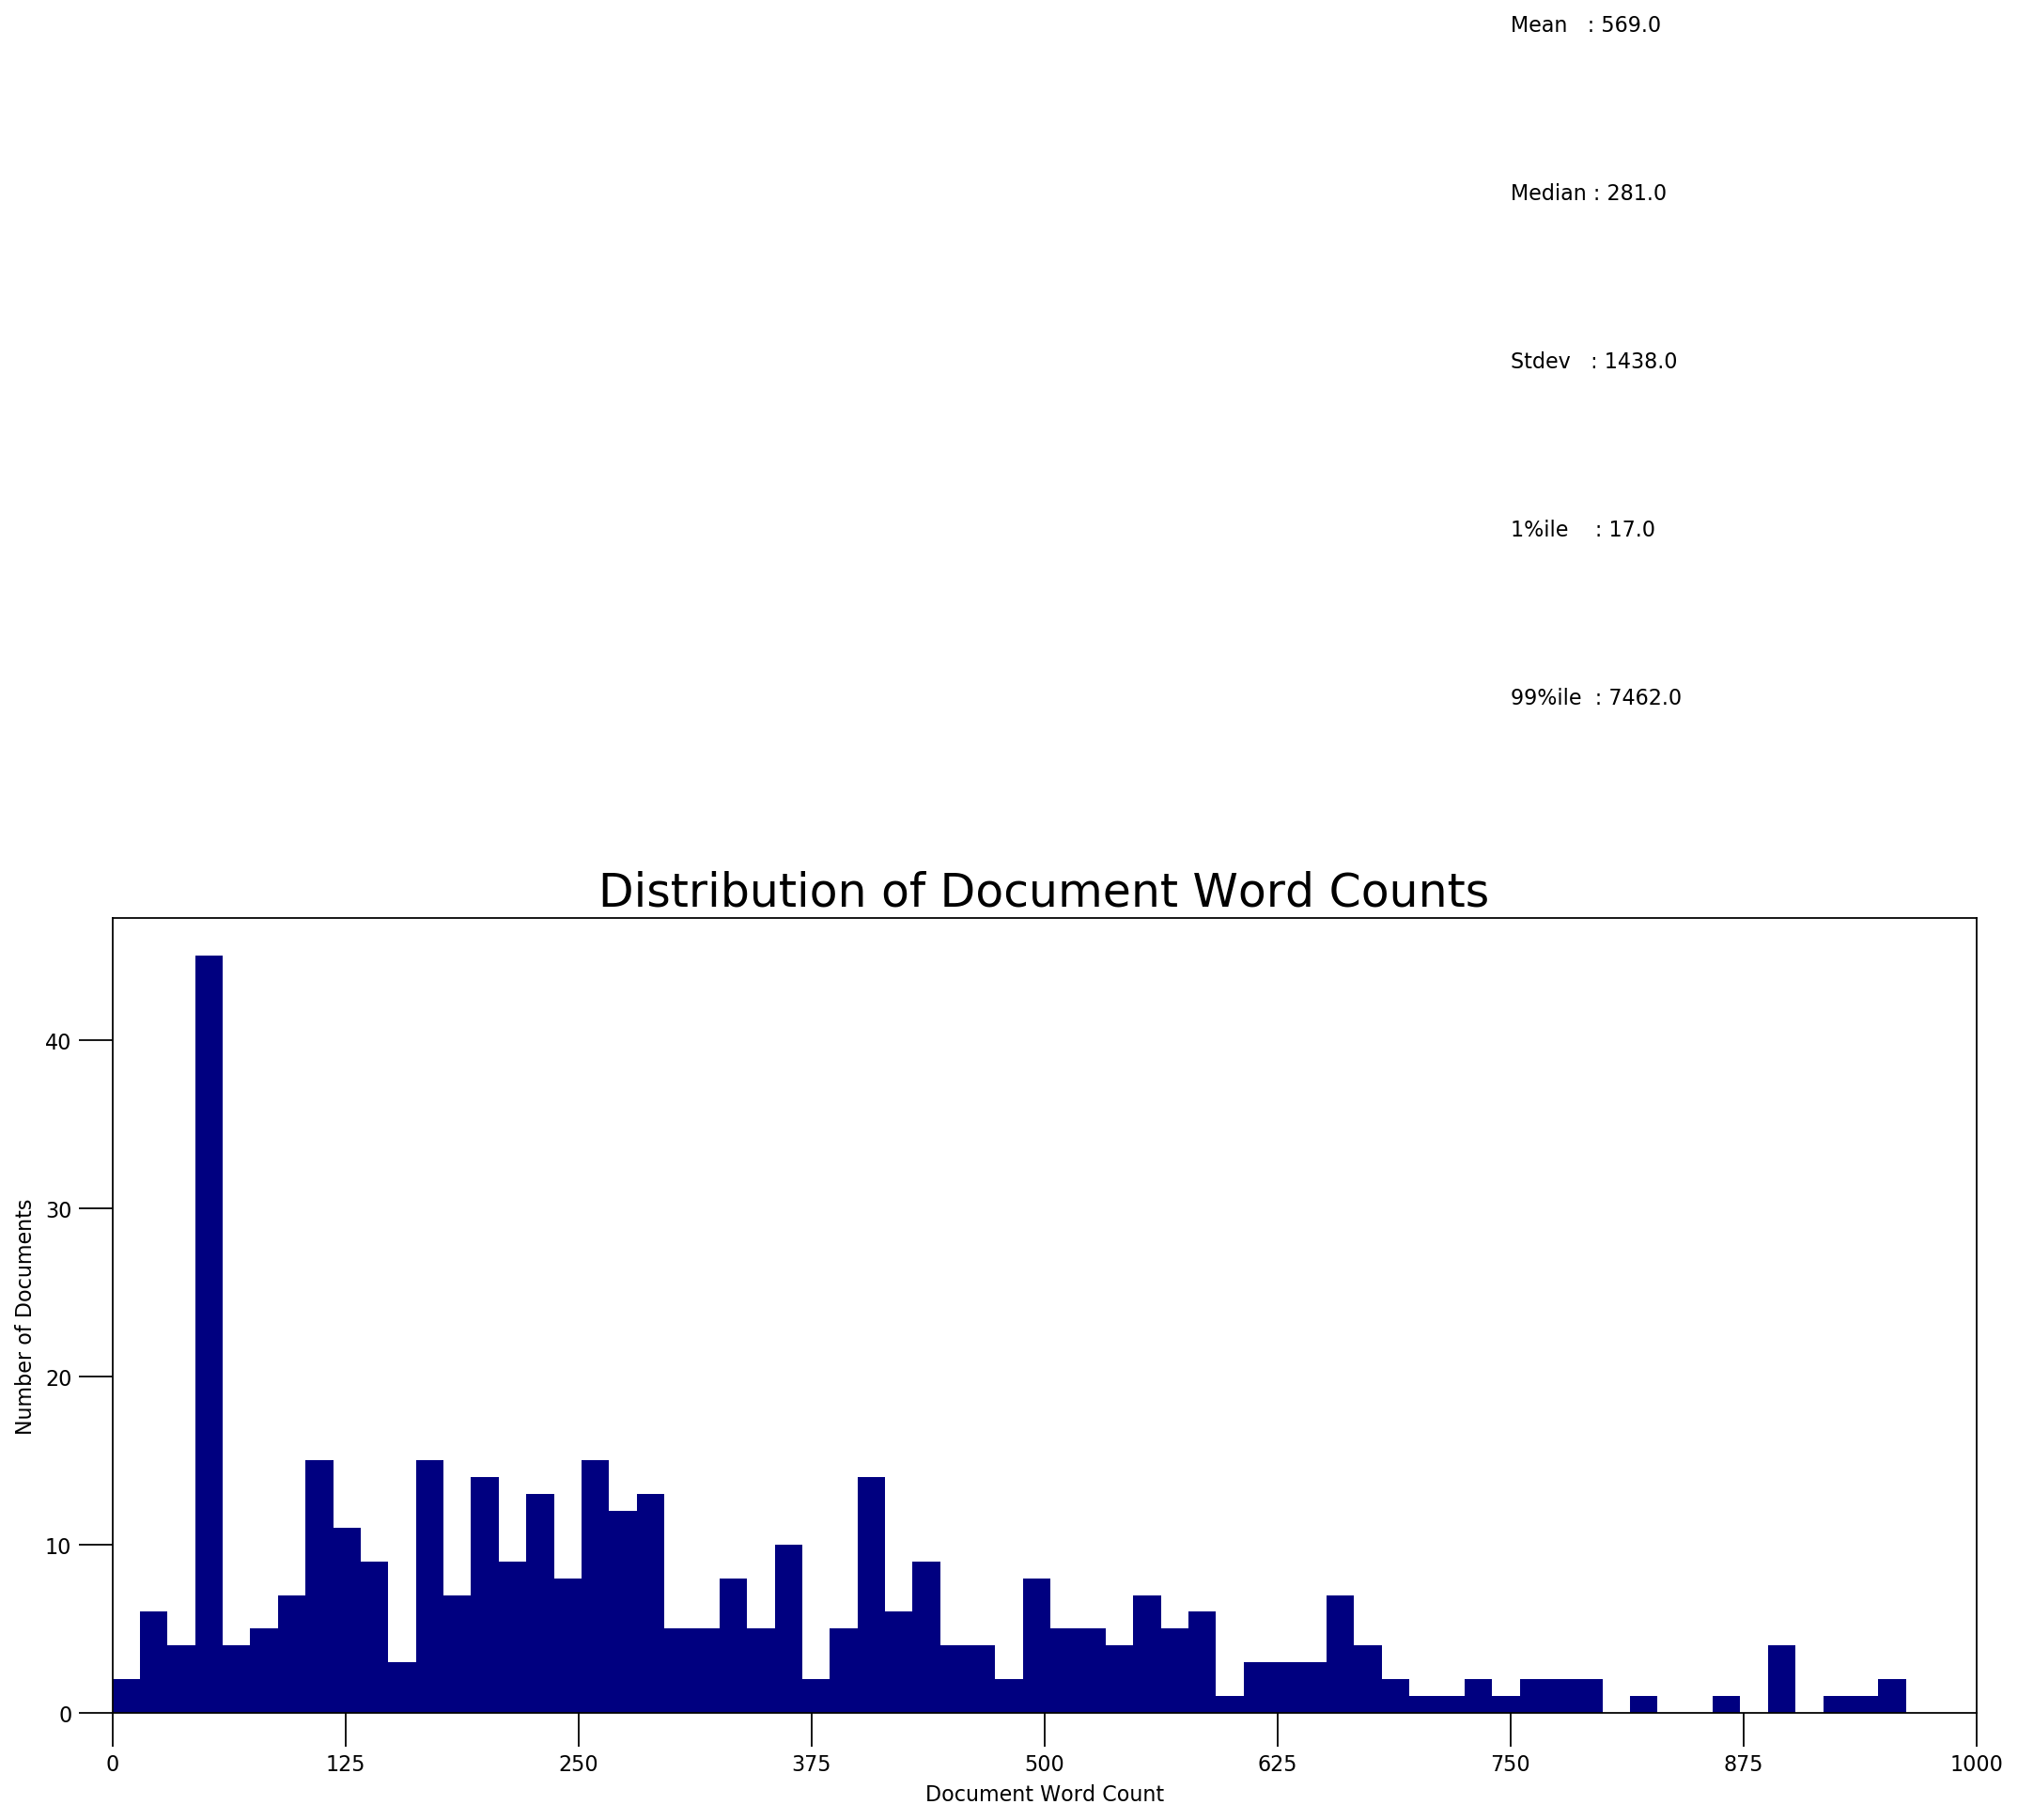

In [314]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

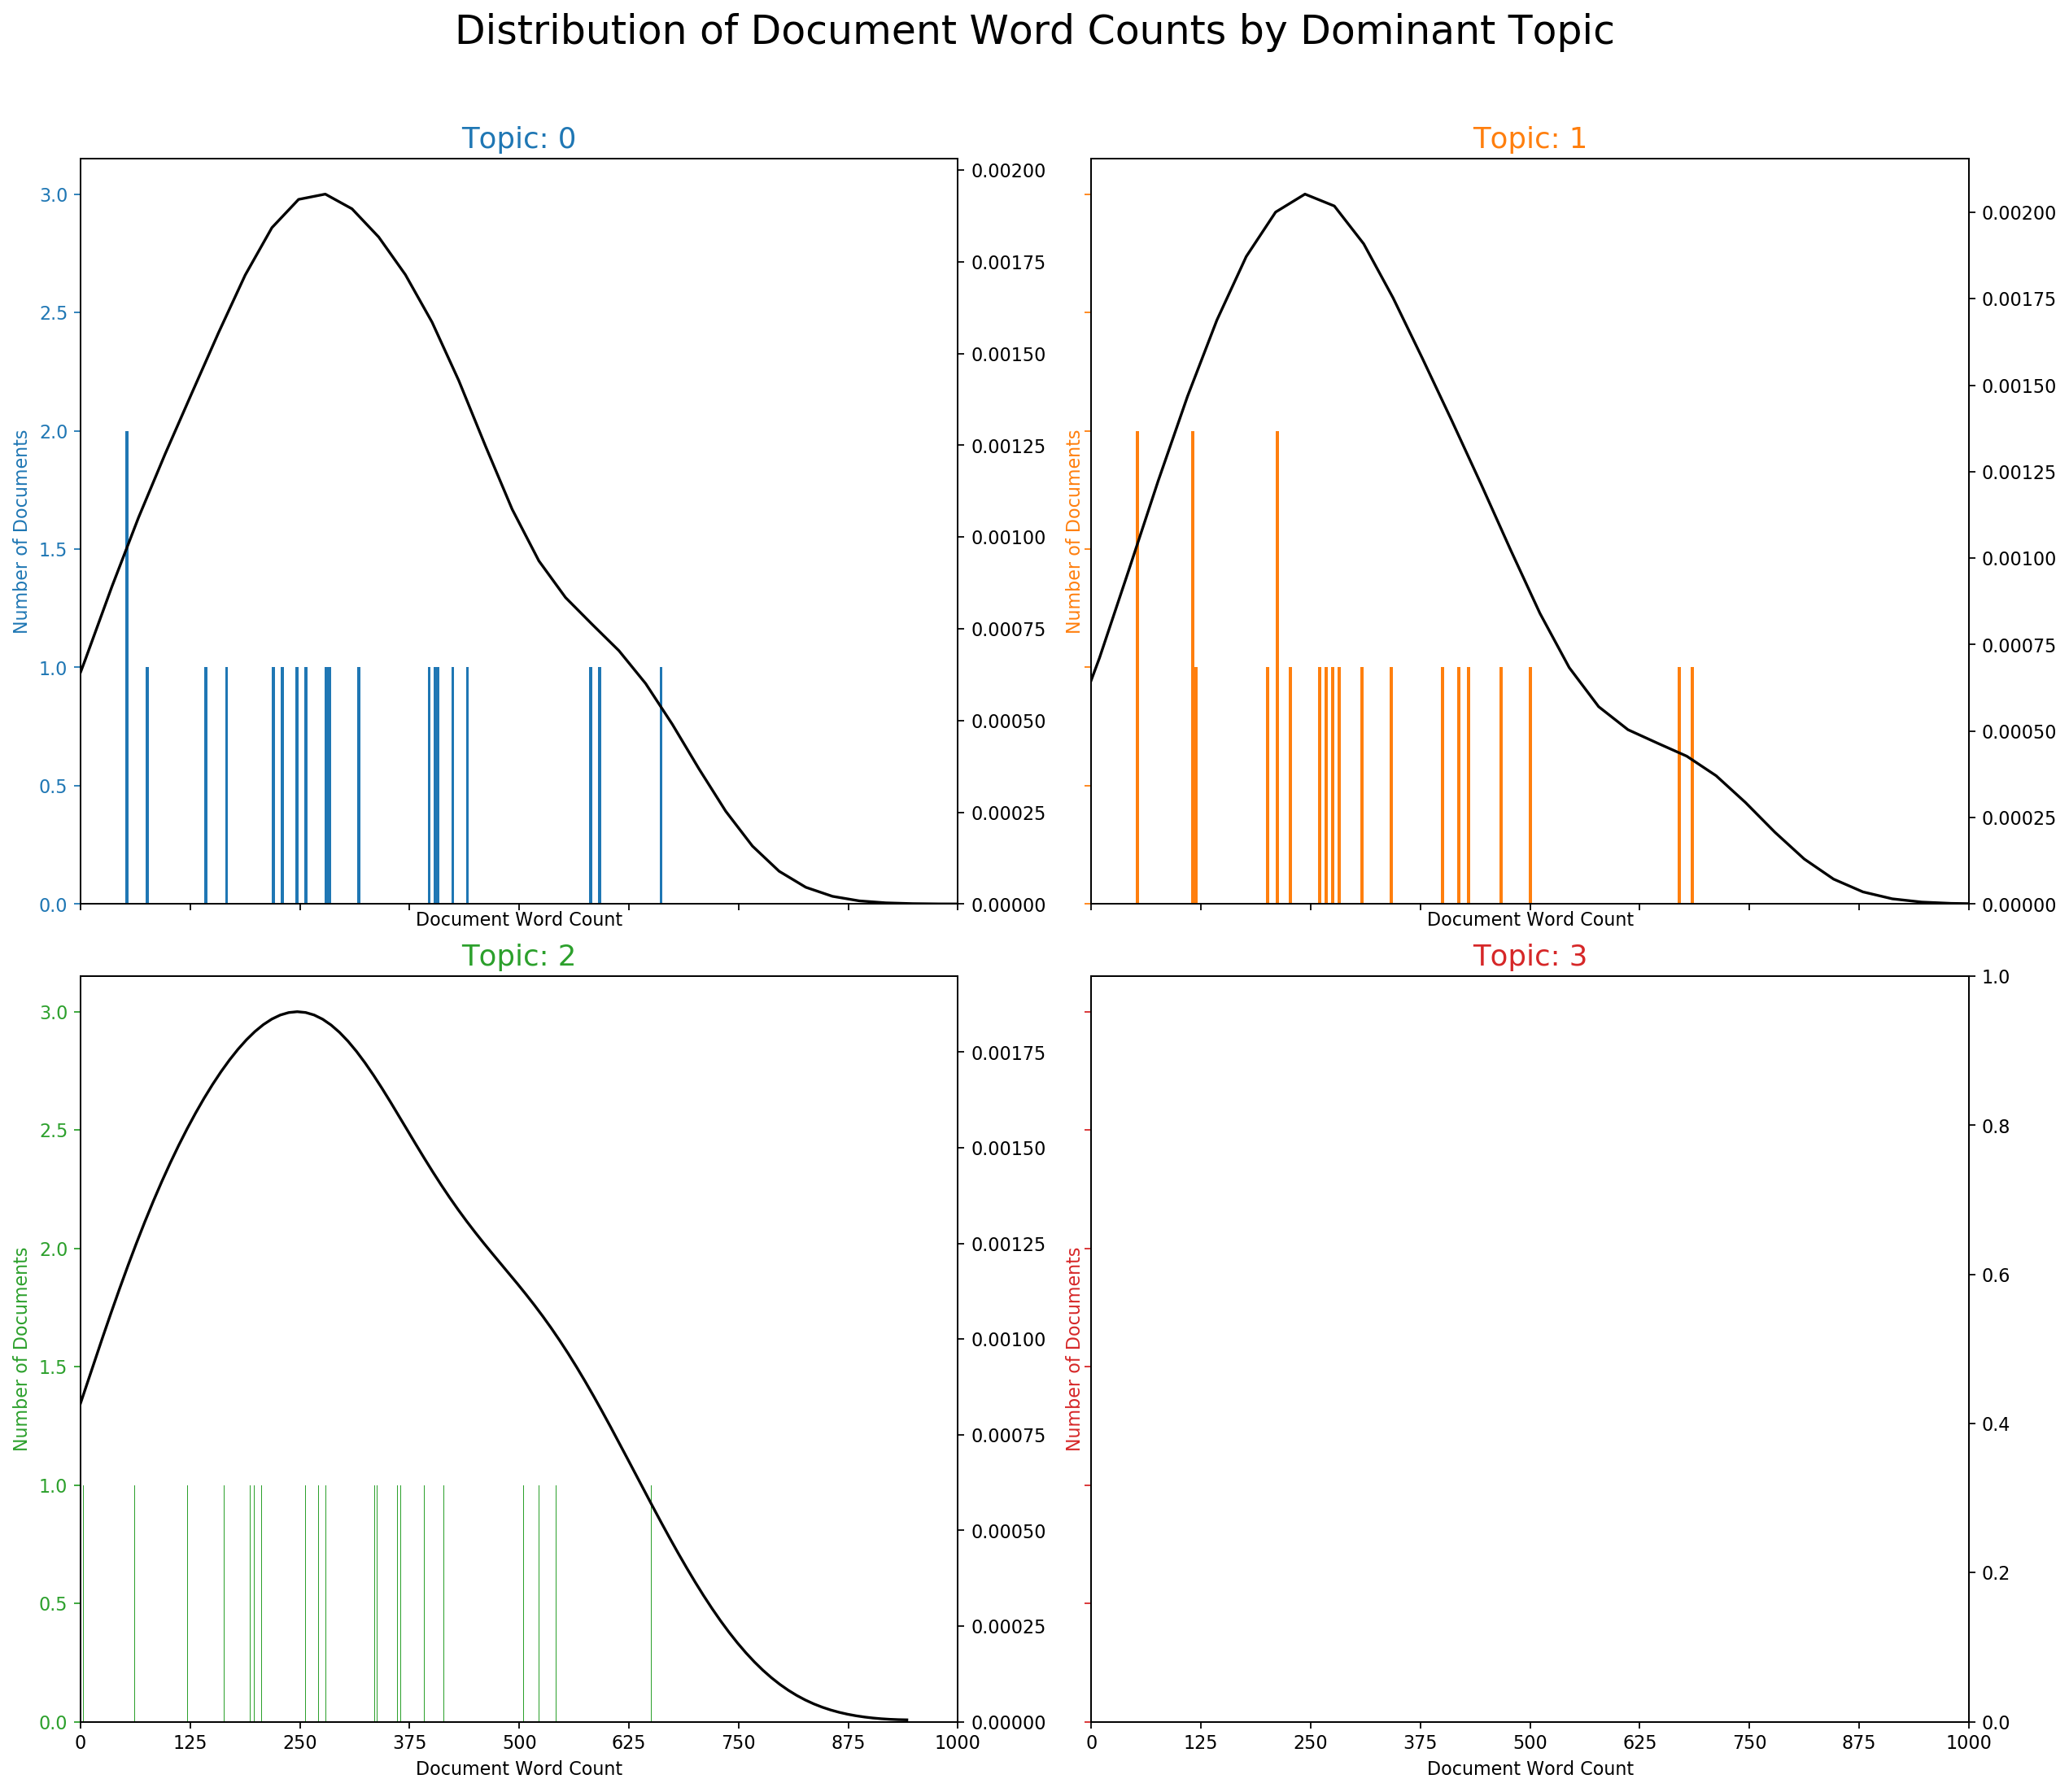

In [315]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

IndexError: list index out of range

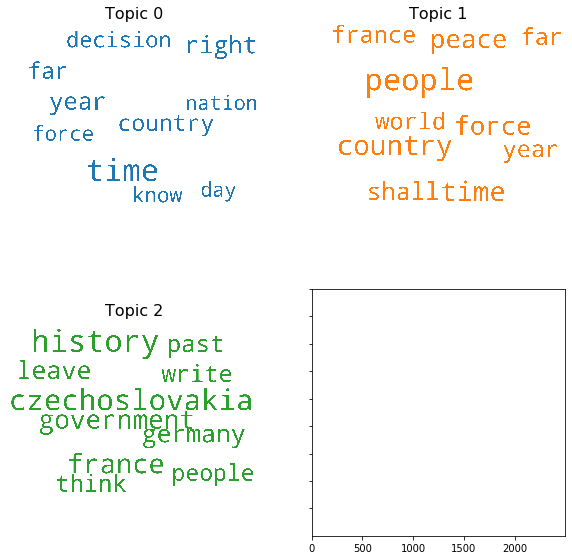

In [316]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## WWII LDA

In [88]:
def make_string(text):
    return ' '.join(text)
w2['preproc']= w2['preproc'].apply(make_string)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [89]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1, 2), lowercase = False,   
                                   stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")

count_vectorizer.fit(w2.preproc)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=False, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
                tokenizer=None, vocabulary=None)

In [90]:
# Create the term-document matrix
# Transpose it so the terms are the rows
w2doc_word = count_vectorizer.transform(w2.preproc).transpose()

In [91]:
import pandas as pd

pd.DataFrame(w2doc_word.toarray(), count_vectorizer.get_feature_names()).head()

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
abandonment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandonment belgium,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abate demand,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abate force,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
w2doc_word.shape

(20457, 228)

In [93]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(w2doc_word)

In [94]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [95]:
len(id2word)

20457

In [96]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=5)

2020-09-15 16:01:43,186 : INFO : using symmetric alpha at 0.2
2020-09-15 16:01:43,189 : INFO : using symmetric eta at 0.2
2020-09-15 16:01:43,193 : INFO : using serial LDA version on this node
2020-09-15 16:01:43,205 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 228 documents, updating model once every 228 documents, evaluating perplexity every 228 documents, iterating 50x with a convergence threshold of 0.001000
2020-09-15 16:01:43,206 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-09-15 16:01:43,854 : INFO : -12.197 per-word bound, 4695.6 perplexity estimate based on a held-out corpus of 228 documents with 39513 words
2020-09-15 16:01:43,855 : INFO : PROGRESS: pass 0, at document #228/228
2020-09-15 16:01:44,124 : INFO : topic #0 (0.200): 0.004*"war" + 0.003*"british" + 0.003*"force" + 0.003*"german" + 0.003*"great" + 0.003*"air" + 0.002*"day"

In [97]:
lda.print_topics()

2020-09-15 16:01:46,106 : INFO : topic #0 (0.200): 0.005*"war" + 0.004*"german" + 0.004*"british" + 0.004*"force" + 0.003*"air" + 0.003*"great" + 0.003*"french" + 0.003*"day" + 0.003*"enemy" + 0.003*"army"
2020-09-15 16:01:46,108 : INFO : topic #1 (0.200): 0.004*"war" + 0.004*"great" + 0.003*"force" + 0.003*"british" + 0.003*"air" + 0.002*"man" + 0.002*"time" + 0.002*"shall" + 0.002*"year" + 0.002*"france"
2020-09-15 16:01:46,109 : INFO : topic #2 (0.200): 0.002*"war" + 0.002*"german" + 0.002*"army" + 0.002*"man" + 0.002*"come" + 0.002*"month" + 0.002*"fight" + 0.002*"battle" + 0.001*"long" + 0.001*"time"
2020-09-15 16:01:46,110 : INFO : topic #3 (0.200): 0.008*"history" + 0.004*"past" + 0.004*"write" + 0.004*"especially" + 0.004*"propose" + 0.004*"leave" + 0.004*"leave past" + 0.004*"write history" + 0.004*"especially propose" + 0.004*"past history"
2020-09-15 16:01:46,112 : INFO : topic #4 (0.200): 0.005*"war" + 0.003*"world" + 0.003*"shall" + 0.003*"people" + 0.003*"time" + 0.002*"r

[(0,
  '0.005*"war" + 0.004*"german" + 0.004*"british" + 0.004*"force" + 0.003*"air" + 0.003*"great" + 0.003*"french" + 0.003*"day" + 0.003*"enemy" + 0.003*"army"'),
 (1,
  '0.004*"war" + 0.004*"great" + 0.003*"force" + 0.003*"british" + 0.003*"air" + 0.002*"man" + 0.002*"time" + 0.002*"shall" + 0.002*"year" + 0.002*"france"'),
 (2,
  '0.002*"war" + 0.002*"german" + 0.002*"army" + 0.002*"man" + 0.002*"come" + 0.002*"month" + 0.002*"fight" + 0.002*"battle" + 0.001*"long" + 0.001*"time"'),
 (3,
  '0.008*"history" + 0.004*"past" + 0.004*"write" + 0.004*"especially" + 0.004*"propose" + 0.004*"leave" + 0.004*"leave past" + 0.004*"write history" + 0.004*"especially propose" + 0.004*"past history"'),
 (4,
  '0.005*"war" + 0.003*"world" + 0.003*"shall" + 0.003*"people" + 0.003*"time" + 0.002*"russian" + 0.002*"great" + 0.002*"man" + 0.002*"unitedstates" + 0.002*"country"')]

#### Add Stop Words

In [98]:
my_stop_words = STOPWORDS.union(set(['war', 'shall', 'especially', 'great', 'history']))

In [99]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1, 2), lowercase = False,   
                                   stop_words=my_stop_words, token_pattern="\\b[a-z][a-z]+\\b")

count_vectorizer.fit(w2.preproc)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=False, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
                tokenizer=None, vocabulary=None)

In [100]:
# Create the term-document matrix
# Transpose it so the terms are the rows
w2doc_word = count_vectorizer.transform(w2.preproc).transpose()

In [101]:
import pandas as pd

pd.DataFrame(w2doc_word.toarray(), count_vectorizer.get_feature_names()).head()

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
abandonment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandonment belgium,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abate demand,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abate force,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(w2doc_word)

In [103]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [104]:
len(id2word)

20088

In [105]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=5)

2020-09-15 16:01:52,793 : INFO : using symmetric alpha at 0.3333333333333333
2020-09-15 16:01:52,794 : INFO : using symmetric eta at 0.3333333333333333
2020-09-15 16:01:52,797 : INFO : using serial LDA version on this node
2020-09-15 16:01:52,805 : INFO : running online (multi-pass) LDA training, 3 topics, 5 passes over the supplied corpus of 228 documents, updating model once every 228 documents, evaluating perplexity every 228 documents, iterating 50x with a convergence threshold of 0.001000
2020-09-15 16:01:52,806 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-09-15 16:01:53,332 : INFO : -11.031 per-word bound, 2092.3 perplexity estimate based on a held-out corpus of 228 documents with 38179 words
2020-09-15 16:01:53,332 : INFO : PROGRESS: pass 0, at document #228/228
2020-09-15 16:01:53,592 : INFO : topic #0 (0.333): 0.002*"air" + 0.002*"british" + 0.002*"man" + 0.002*"force" + 0.002*"french"

In [106]:
lda.print_topics()

2020-09-15 16:01:55,547 : INFO : topic #0 (0.333): 0.002*"army" + 0.002*"day" + 0.002*"british" + 0.002*"french" + 0.002*"air" + 0.002*"force" + 0.002*"man" + 0.002*"people" + 0.001*"german" + 0.001*"time"
2020-09-15 16:01:55,550 : INFO : topic #1 (0.333): 0.003*"german" + 0.002*"air" + 0.002*"force" + 0.002*"man" + 0.002*"british" + 0.002*"time" + 0.002*"long" + 0.002*"day" + 0.002*"fight" + 0.002*"year"
2020-09-15 16:01:55,552 : INFO : topic #2 (0.333): 0.003*"british" + 0.003*"force" + 0.003*"time" + 0.003*"man" + 0.003*"world" + 0.003*"air" + 0.002*"french" + 0.002*"country" + 0.002*"german" + 0.002*"day"


[(0,
  '0.002*"army" + 0.002*"day" + 0.002*"british" + 0.002*"french" + 0.002*"air" + 0.002*"force" + 0.002*"man" + 0.002*"people" + 0.001*"german" + 0.001*"time"'),
 (1,
  '0.003*"german" + 0.002*"air" + 0.002*"force" + 0.002*"man" + 0.002*"british" + 0.002*"time" + 0.002*"long" + 0.002*"day" + 0.002*"fight" + 0.002*"year"'),
 (2,
  '0.003*"british" + 0.003*"force" + 0.003*"time" + 0.003*"man" + 0.003*"world" + 0.003*"air" + 0.002*"french" + 0.002*"country" + 0.002*"german" + 0.002*"day"')]

In [107]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1, 2), lowercase = False, min_df=0.01, max_df=0.8,   
                                   stop_words=my_stop_words, token_pattern="\\b[a-z][a-z]+\\b")

count_vectorizer.fit(w2.preproc)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=False, max_df=0.8, max_features=None, min_df=0.01,
                ngram_range=(1, 2), preprocessor=None,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
                tokenizer=None, vocabulary=None)

In [108]:
w2doc_word = count_vectorizer.transform(w2.preproc).transpose()

In [109]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(w2doc_word)

In [110]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [111]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=5)

2020-09-15 16:01:59,239 : INFO : using symmetric alpha at 0.3333333333333333
2020-09-15 16:01:59,240 : INFO : using symmetric eta at 0.3333333333333333
2020-09-15 16:01:59,241 : INFO : using serial LDA version on this node
2020-09-15 16:01:59,243 : INFO : running online (multi-pass) LDA training, 3 topics, 5 passes over the supplied corpus of 228 documents, updating model once every 228 documents, evaluating perplexity every 228 documents, iterating 50x with a convergence threshold of 0.001000
2020-09-15 16:01:59,244 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-09-15 16:01:59,557 : INFO : -8.037 per-word bound, 262.7 perplexity estimate based on a held-out corpus of 228 documents with 17016 words
2020-09-15 16:01:59,558 : INFO : PROGRESS: pass 0, at document #228/228
2020-09-15 16:01:59,733 : INFO : topic #0 (0.333): 0.009*"air" + 0.009*"man" + 0.008*"day" + 0.007*"people" + 0.007*"time" + 0.00

In [112]:
lda.print_topics()

2020-09-15 16:02:02,126 : INFO : topic #0 (0.333): 0.010*"man" + 0.008*"day" + 0.008*"air" + 0.008*"people" + 0.007*"past" + 0.006*"time" + 0.006*"leave" + 0.006*"month" + 0.006*"write" + 0.006*"army"
2020-09-15 16:02:02,127 : INFO : topic #1 (0.333): 0.008*"long" + 0.008*"german" + 0.008*"unitedstates" + 0.007*"general" + 0.007*"force" + 0.006*"air" + 0.006*"british" + 0.006*"churchill" + 0.005*"house" + 0.005*"sign"
2020-09-15 16:02:02,128 : INFO : topic #2 (0.333): 0.010*"british" + 0.009*"force" + 0.008*"time" + 0.007*"french" + 0.007*"air" + 0.007*"world" + 0.007*"german" + 0.007*"fight" + 0.006*"man" + 0.006*"army"


[(0,
  '0.010*"man" + 0.008*"day" + 0.008*"air" + 0.008*"people" + 0.007*"past" + 0.006*"time" + 0.006*"leave" + 0.006*"month" + 0.006*"write" + 0.006*"army"'),
 (1,
  '0.008*"long" + 0.008*"german" + 0.008*"unitedstates" + 0.007*"general" + 0.007*"force" + 0.006*"air" + 0.006*"british" + 0.006*"churchill" + 0.005*"house" + 0.005*"sign"'),
 (2,
  '0.010*"british" + 0.009*"force" + 0.008*"time" + 0.007*"french" + 0.007*"air" + 0.007*"world" + 0.007*"german" + 0.007*"fight" + 0.006*"man" + 0.006*"army"')]

In [113]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(lda[corpus]):
        row = row_list[0] if lda.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.sort_values('Topic_Perc_Contrib')
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.9877,"british, force, time, french, air, world, german, fight, man, army",wonder happen war month past nazis utter ferocious threat go western democracies british french ...
1,1,2.0,0.9092,"british, force, time, french, air, world, german, fight, man, army",happen neutral nation mention mention spontaneous impulse duty
2,2,0.0,0.9163,"man, day, air, people, past, time, leave, month, write, army",leave past history especially propose write history
3,3,2.0,0.9851,"british, force, time, french, air, world, german, fight, man, army",aggrieve belligerent powers wage war germany need ask respite week commerce grow month organizat...
4,4,2.0,0.9741,"british, force, time, french, air, world, german, fight, man, army",magnetic mine narrow water approach island strew present problem deem insoluble remember war suf...
5,5,2.0,0.9889,"british, force, time, french, air, world, german, fight, man, army",accordance covenant league stand british french empires aggression wrong present plight lamentab...
6,6,2.0,0.9202,"british, force, time, french, air, world, german, fight, man, army",different lot unfortunate neutral sea land victim hitler hate spite descend look group small anc...
7,7,2.0,0.9899,"british, force, time, french, air, world, german, fight, man, army",nearly month sea u boat campaign time utterly break mine menace good control ship virtually undi...
8,8,0.0,0.9752,"man, day, air, people, past, time, leave, month, write, army",bitter increasingly exact conflict lie resolve outstrip service common cause let great city wars...
9,9,2.0,0.9907,"british, force, time, french, air, world, german, fight, man, army",thing helpful determine action neutral increase sense power resolution western allies small stat...


In [114]:
speeches_df[speeches_df['Speech'].str.contains("aggrieve")]

,Title,Speech,Year,Clean,preproc
3,"A House of Many Mansions, 1940","We, the aggrieved and belligerent Powers who are waging war against Germany, have no need to ask...",1940,the aggrieved and belligerent Powers who are waging war against Germany have need ask for respit...,"[aggrieve, belligerent, powers, wage, war, germany, need, ask, respite, week, commerce, grow, mo..."


In [115]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9951,"man, day, air, people, past, time, leave, month, write, army",leave past history especially propose write history
1,1.0,0.9984,"long, german, unitedstates, general, force, air, british, churchill, house, sign",spectacled brass hat future world agony extinguish london paris tokyo san francisco press button...
2,2.0,0.9995,"british, force, time, french, air, world, german, fight, man, army",engage civil defence force london country prepare heavy assault oiganization vigilance yoor devo...


In [116]:
df_dominant_topic.to_csv(r'C:\Users\krystynametcalf\Desktop\WWdf.csv', index=False) 

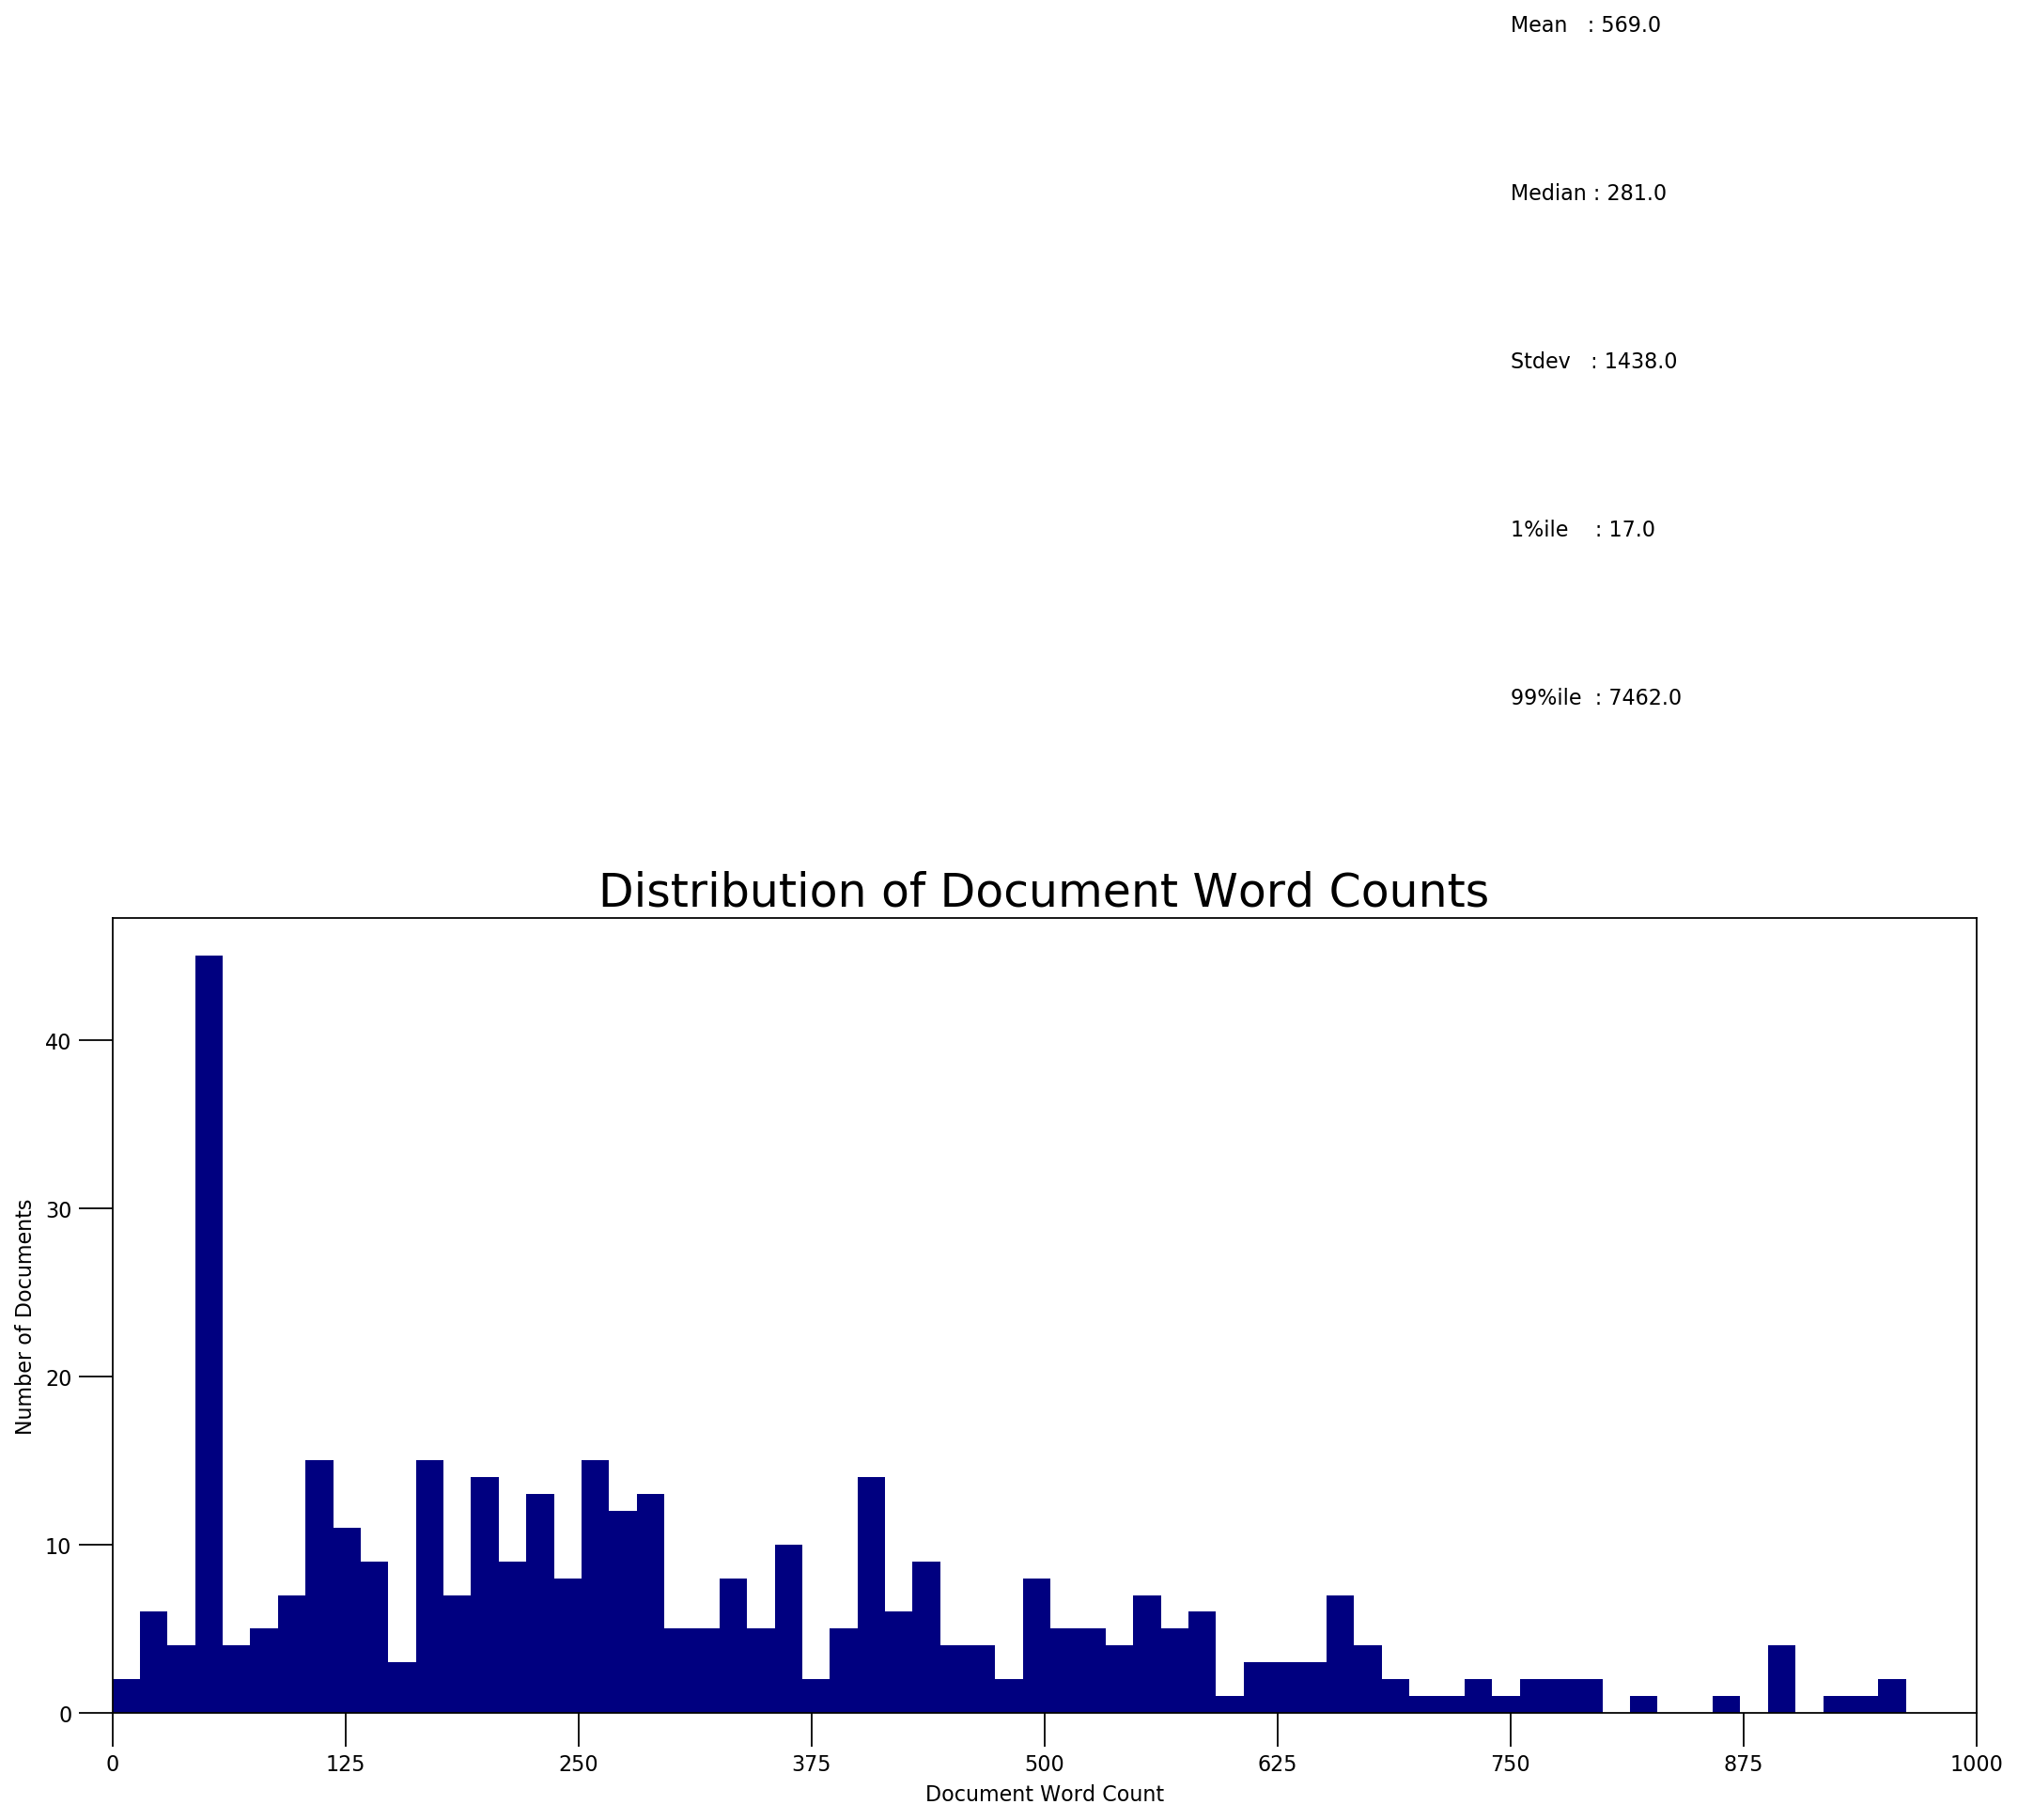

In [419]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

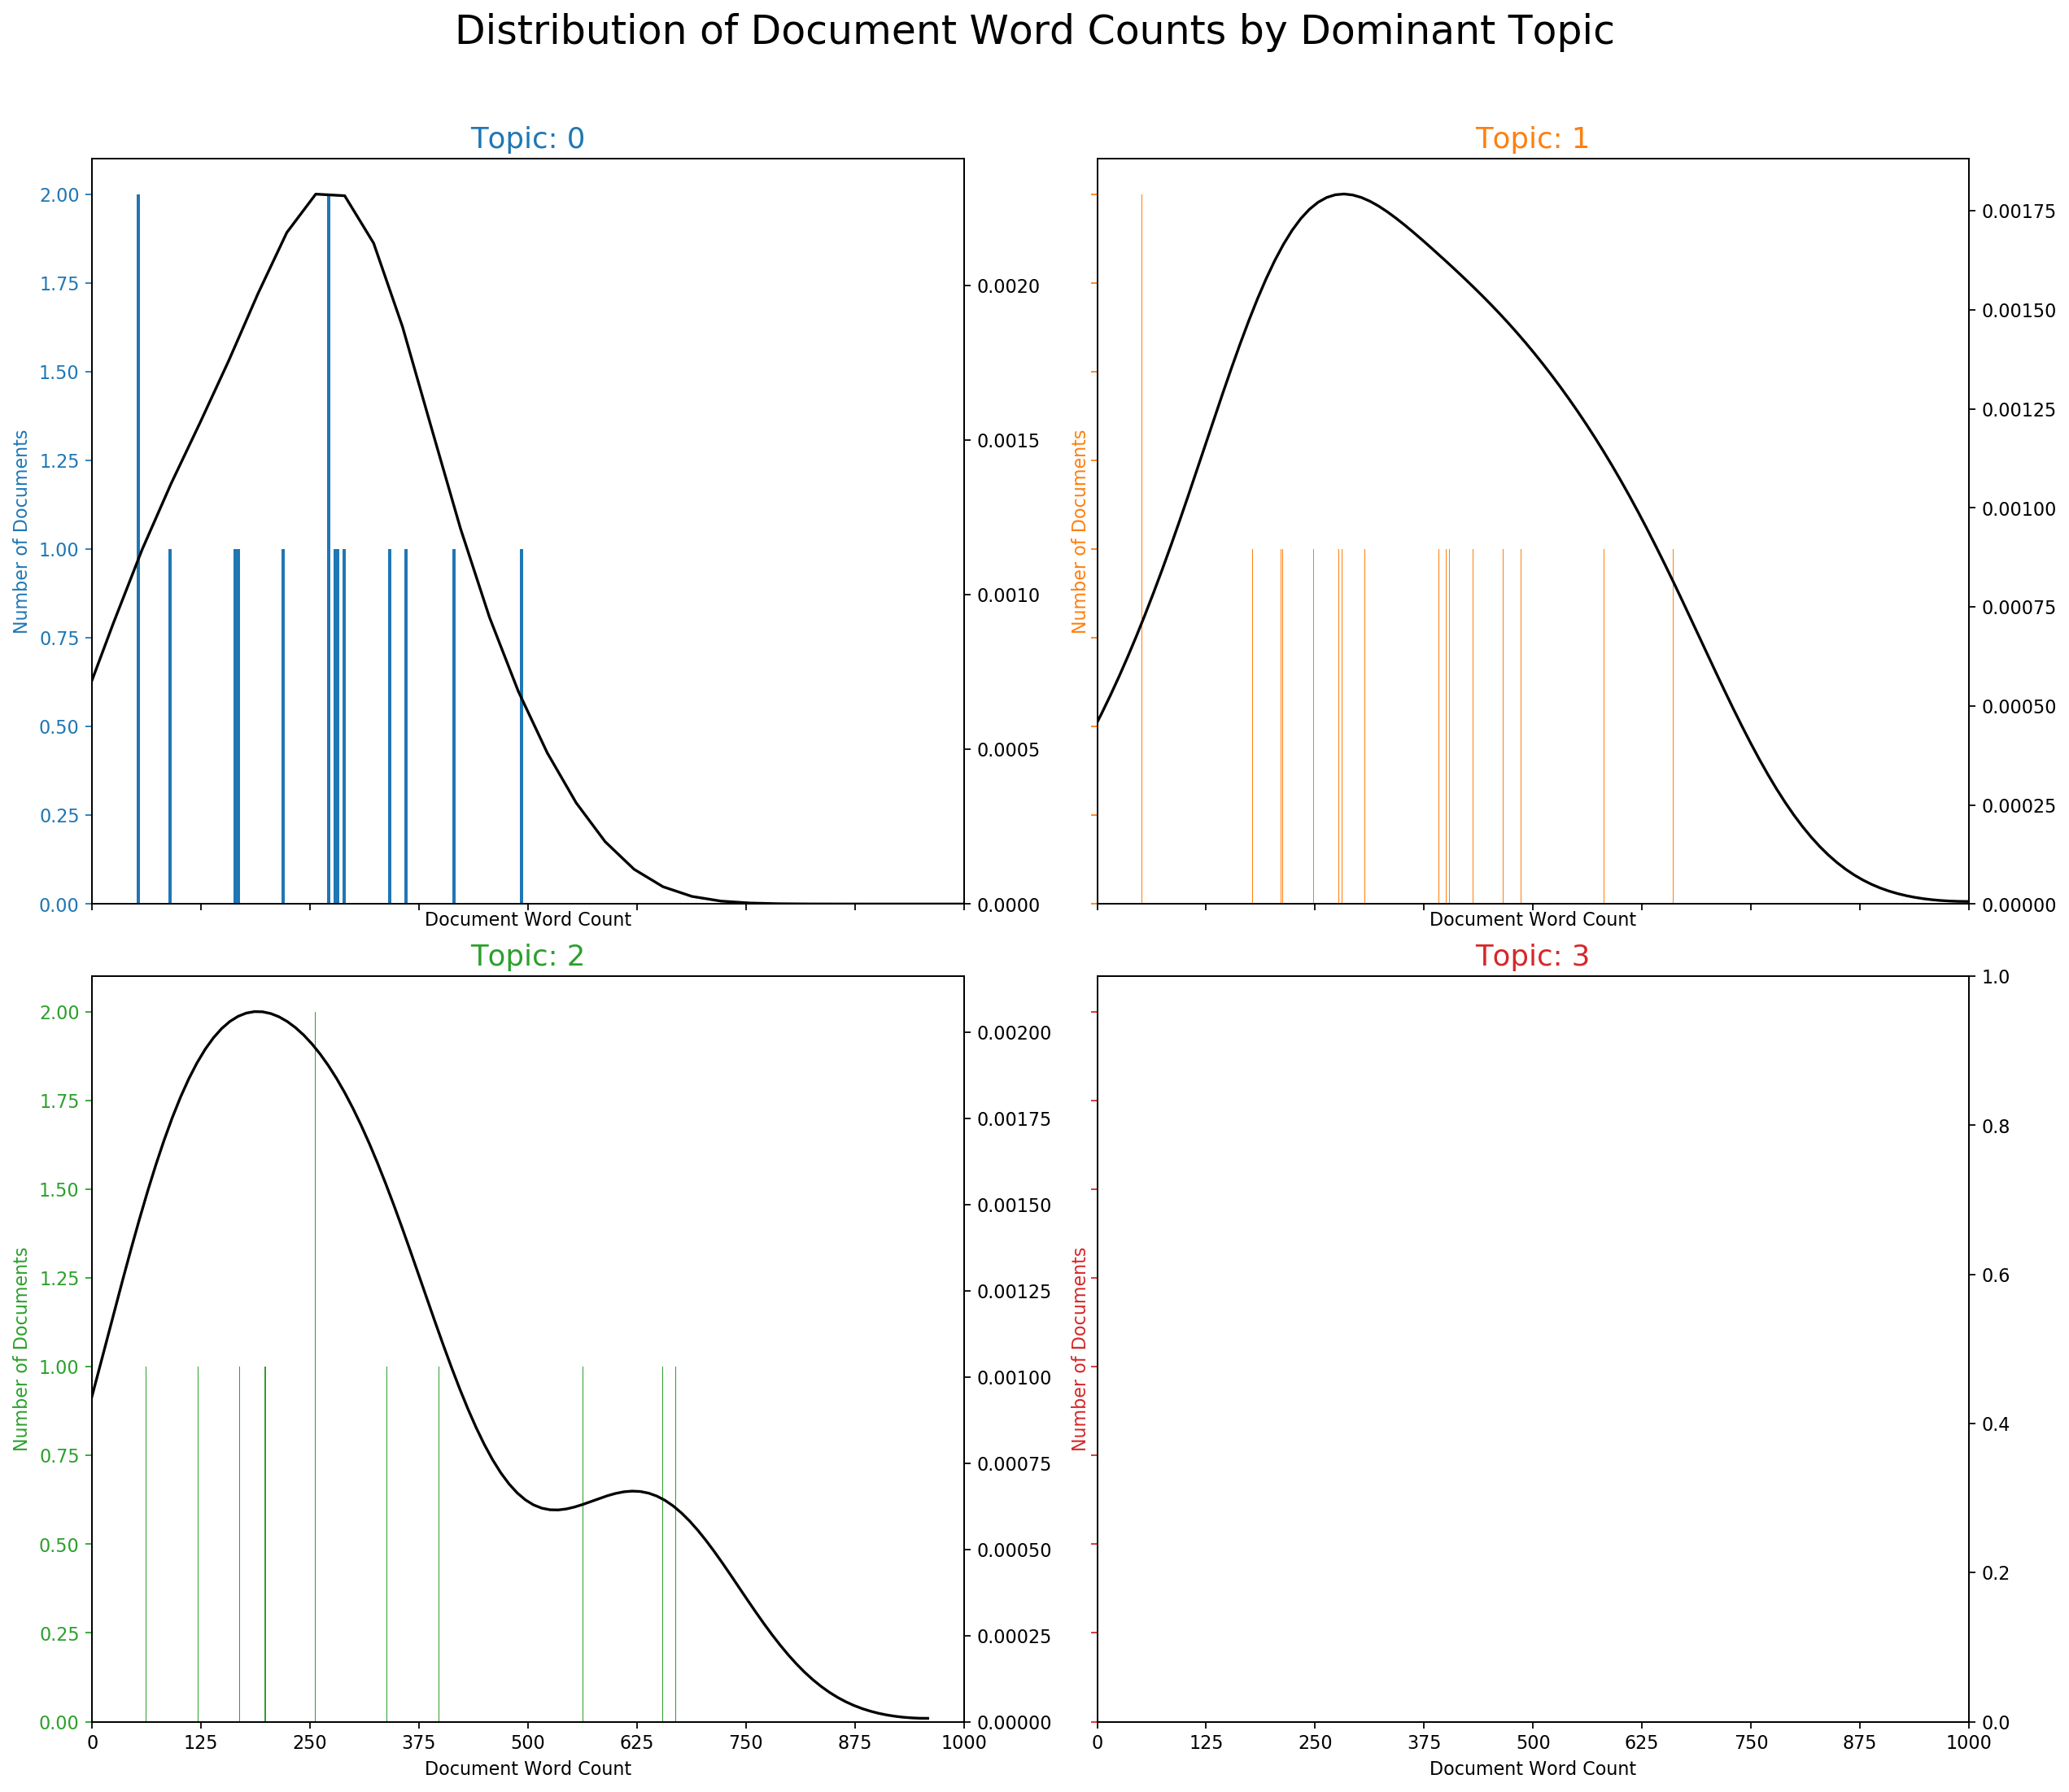

In [420]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

IndexError: list index out of range

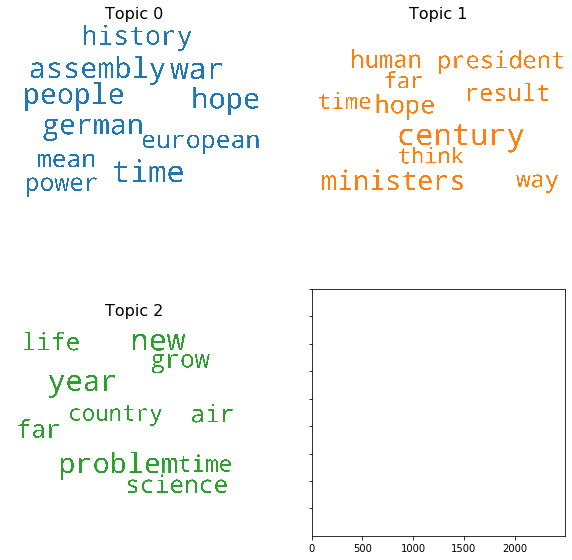

In [421]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Post War

In [117]:
def make_string(text):
    return ' '.join(text)
PW['preproc']= PW['preproc'].apply(make_string)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [118]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1, 2), lowercase = False,   
                                   stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")

count_vectorizer.fit(PW.preproc)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=False, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
                tokenizer=None, vocabulary=None)

In [119]:
# Create the term-document matrix
# Transpose it so the terms are the rows
PWdoc_word = count_vectorizer.transform(PW.preproc).transpose()

In [120]:
import pandas as pd

pd.DataFrame(PWdoc_word.toarray(), count_vectorizer.get_feature_names()).head()

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
abandon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandon hope,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ability,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ability control,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
able,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [121]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(PWdoc_word)

In [122]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [123]:
len(id2word)

4129

In [124]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=5)

2020-09-15 16:02:35,120 : INFO : using symmetric alpha at 0.3333333333333333
2020-09-15 16:02:35,121 : INFO : using symmetric eta at 0.3333333333333333
2020-09-15 16:02:35,123 : INFO : using serial LDA version on this node
2020-09-15 16:02:35,125 : INFO : running online (multi-pass) LDA training, 3 topics, 5 passes over the supplied corpus of 56 documents, updating model once every 56 documents, evaluating perplexity every 56 documents, iterating 50x with a convergence threshold of 0.001000
2020-09-15 16:02:35,126 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-09-15 16:02:35,217 : INFO : -9.722 per-word bound, 844.4 perplexity estimate based on a held-out corpus of 56 documents with 5688 words
2020-09-15 16:02:35,218 : INFO : PROGRESS: pass 0, at document #56/56
2020-09-15 16:02:35,276 : INFO : topic #0 (0.333): 0.005*"world" + 0.003*"great" + 0.003*"hope" + 0.002*"century" + 0.002*"man" + 0.002*

In [125]:
lda.print_topics()

2020-09-15 16:02:37,327 : INFO : topic #0 (0.333): 0.005*"world" + 0.003*"great" + 0.002*"century" + 0.002*"committee" + 0.002*"europe" + 0.002*"hope" + 0.002*"like" + 0.002*"time" + 0.002*"president" + 0.002*"german"
2020-09-15 16:02:37,328 : INFO : topic #1 (0.333): 0.006*"world" + 0.003*"europe" + 0.003*"man" + 0.002*"great" + 0.002*"assembly" + 0.002*"long" + 0.002*"new" + 0.002*"speak" + 0.002*"bring" + 0.002*"shall"
2020-09-15 16:02:37,329 : INFO : topic #2 (0.333): 0.003*"year" + 0.002*"world" + 0.002*"committee" + 0.002*"history" + 0.002*"air" + 0.002*"way" + 0.002*"human" + 0.002*"hope" + 0.002*"time" + 0.002*"far"


[(0,
  '0.005*"world" + 0.003*"great" + 0.002*"century" + 0.002*"committee" + 0.002*"europe" + 0.002*"hope" + 0.002*"like" + 0.002*"time" + 0.002*"president" + 0.002*"german"'),
 (1,
  '0.006*"world" + 0.003*"europe" + 0.003*"man" + 0.002*"great" + 0.002*"assembly" + 0.002*"long" + 0.002*"new" + 0.002*"speak" + 0.002*"bring" + 0.002*"shall"'),
 (2,
  '0.003*"year" + 0.002*"world" + 0.002*"committee" + 0.002*"history" + 0.002*"air" + 0.002*"way" + 0.002*"human" + 0.002*"hope" + 0.002*"time" + 0.002*"far"')]

### Stop Words

In [126]:
my_stop_words = STOPWORDS.union(set(['world', 'great', 'europe', 'shall', 'bring', 'committee', 'command', 'man', 'like']))

In [127]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1, 2), lowercase = False,   
                                   stop_words=my_stop_words, token_pattern="\\b[a-z][a-z]+\\b")

count_vectorizer.fit(PW.preproc)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=False, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
                tokenizer=None, vocabulary=None)

In [128]:
PWdoc_word = count_vectorizer.transform(PW.preproc).transpose()

In [129]:
corpus = matutils.Sparse2Corpus(PWdoc_word)

In [130]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [131]:
len(id2word)

3979

In [132]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=5)

2020-09-15 16:02:42,184 : INFO : using symmetric alpha at 0.3333333333333333
2020-09-15 16:02:42,185 : INFO : using symmetric eta at 0.3333333333333333
2020-09-15 16:02:42,187 : INFO : using serial LDA version on this node
2020-09-15 16:02:42,189 : INFO : running online (multi-pass) LDA training, 3 topics, 5 passes over the supplied corpus of 56 documents, updating model once every 56 documents, evaluating perplexity every 56 documents, iterating 50x with a convergence threshold of 0.001000
2020-09-15 16:02:42,190 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-09-15 16:02:42,276 : INFO : -9.710 per-word bound, 837.4 perplexity estimate based on a held-out corpus of 56 documents with 5354 words
2020-09-15 16:02:42,277 : INFO : PROGRESS: pass 0, at document #56/56
2020-09-15 16:02:42,338 : INFO : topic #0 (0.333): 0.002*"hope" + 0.002*"time" + 0.002*"war" + 0.002*"long" + 0.002*"assembly" + 0.002*"

In [133]:
lda.print_topics()

2020-09-15 16:02:44,190 : INFO : topic #0 (0.333): 0.003*"hope" + 0.002*"time" + 0.002*"assembly" + 0.002*"long" + 0.002*"science" + 0.002*"certainly" + 0.002*"european" + 0.002*"war" + 0.002*"mean" + 0.002*"peace"
2020-09-15 16:02:44,192 : INFO : topic #1 (0.333): 0.003*"ministers" + 0.003*"century" + 0.003*"history" + 0.002*"hope" + 0.002*"people" + 0.002*"war" + 0.002*"problem" + 0.002*"time" + 0.002*"subject" + 0.002*"think"
2020-09-15 16:02:44,193 : INFO : topic #2 (0.333): 0.003*"year" + 0.003*"far" + 0.002*"human" + 0.002*"german" + 0.002*"new" + 0.002*"president" + 0.002*"long" + 0.002*"time" + 0.002*"result" + 0.001*"people"


[(0,
  '0.003*"hope" + 0.002*"time" + 0.002*"assembly" + 0.002*"long" + 0.002*"science" + 0.002*"certainly" + 0.002*"european" + 0.002*"war" + 0.002*"mean" + 0.002*"peace"'),
 (1,
  '0.003*"ministers" + 0.003*"century" + 0.003*"history" + 0.002*"hope" + 0.002*"people" + 0.002*"war" + 0.002*"problem" + 0.002*"time" + 0.002*"subject" + 0.002*"think"'),
 (2,
  '0.003*"year" + 0.003*"far" + 0.002*"human" + 0.002*"german" + 0.002*"new" + 0.002*"president" + 0.002*"long" + 0.002*"time" + 0.002*"result" + 0.001*"people"')]

In [134]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(lda[corpus]):
        row = row_list[0] if lda.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.sort_values('Topic_Perc_Contrib')
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.9956,"year, far, human, german, new, president, long, time, result, people",wonder happen war month past nazis utter ferocious threat go western democracies british french ...
1,1,2.0,0.9957,"year, far, human, german, new, president, long, time, result, people",happen neutral nation mention mention spontaneous impulse duty
2,2,2.0,0.9917,"year, far, human, german, new, president, long, time, result, people",leave past history especially propose write history
3,3,1.0,0.9952,"ministers, century, history, hope, people, war, problem, time, subject, think",aggrieve belligerent powers wage war germany need ask respite week commerce grow month organizat...
4,4,0.0,0.9927,"hope, time, assembly, long, science, certainly, european, war, mean, peace",magnetic mine narrow water approach island strew present problem deem insoluble remember war suf...
5,5,0.0,0.9937,"hope, time, assembly, long, science, certainly, european, war, mean, peace",accordance covenant league stand british french empires aggression wrong present plight lamentab...
6,6,1.0,0.9841,"ministers, century, history, hope, people, war, problem, time, subject, think",different lot unfortunate neutral sea land victim hitler hate spite descend look group small anc...
7,7,1.0,0.9972,"ministers, century, history, hope, people, war, problem, time, subject, think",nearly month sea u boat campaign time utterly break mine menace good control ship virtually undi...
8,8,1.0,0.9962,"ministers, century, history, hope, people, war, problem, time, subject, think",bitter increasingly exact conflict lie resolve outstrip service common cause let great city wars...
9,9,0.0,0.9952,"hope, time, assembly, long, science, certainly, european, war, mean, peace",thing helpful determine action neutral increase sense power resolution western allies small stat...


In [135]:
speeches_df[speeches_df['Speech'].str.contains("propose")]

,Title,Speech,Year,Clean,preproc
2,"A House of Many Mansions, 1940",“Leave the past to history especially as I propose to write that history myself.”,1940,Leave the past history especially propose write that history myself,"[leave, past, history, especially, propose, write, history]"
13,"A Hush Over Europe, 1939",“Leave the past to history especially as I propose to write that history myself.”,1939,Leave the past history especially propose write that history myself,"[leave, past, history, especially, propose, write, history]"
14,"Abdication of King Edward VIII, 1936",“Leave the past to history especially as I propose to write that history myself.”,1936,Leave the past history especially propose write that history myself,"[leave, past, history, especially, propose, write, history]"
52,"Address to Joint Session of US Congress, 1941",“Leave the past to history especially as I propose to write that history myself.”,1941,Leave the past history especially propose write that history myself,"[leave, past, history, especially, propose, write, history]"
53,Be Ye Men of Valour,“Leave the past to history especially as I propose to write that history myself.”,1940,Leave the past history especially propose write that history myself,"[leave, past, history, especially, propose, write, history]"
55,"Blood, Toil, Tears and Sweat, 1940",I considered it in the public interest to suggest that the House should be summoned to meet toda...,1940,considered the public interest suggest that the House should summoned meet today Speaker agreed ...,"[consider, public, interest, suggest, house, summon, meet, today, speaker, agree, take, necessar..."
58,"Blood, Toil, Tears and Sweat, 1940",“Leave the past to history especially as I propose to write that history myself.”,1940,Leave the past history especially propose write that history myself,"[leave, past, history, especially, propose, write, history]"
72,"Bolshevism and Imperial Sedition, 1920",“Leave the past to history especially as I propose to write that history myself.”,1920,Leave the past history especially propose write that history myself,"[leave, past, history, especially, propose, write, history]"
79,"Christmas Message, 1941",“Leave the past to history especially as I propose to write that history myself.”,1941,Leave the past history especially propose write that history myself,"[leave, past, history, especially, propose, write, history]"
81,"Churchill Letter to Churchill, 1899",“Leave the past to history especially as I propose to write that history myself.”,1899,Leave the past history especially propose write that history myself,"[leave, past, history, especially, propose, write, history]"


In [136]:
speeches_df.to_csv(r'C:\Users\krystynametcalf\Desktop\speeches_df.csv', index=False) 

In [137]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9971,"hope, time, assembly, long, science, certainly, european, war, mean, peace",prove pestilence break old world carry destructive ravage new world afoot new world escape duty ...
1,1.0,0.9972,"ministers, century, history, hope, people, war, problem, time, subject, think",nearly month sea u boat campaign time utterly break mine menace good control ship virtually undi...
2,2.0,0.9957,"year, far, human, german, new, president, long, time, result, people",word specially door underrate number poignantly afflict occur danger gather path afford right lo...


In [138]:
df_dominant_topic.to_csv(r'C:\Users\krystynametcalf\Desktop\PWdf.csv', index=False) 

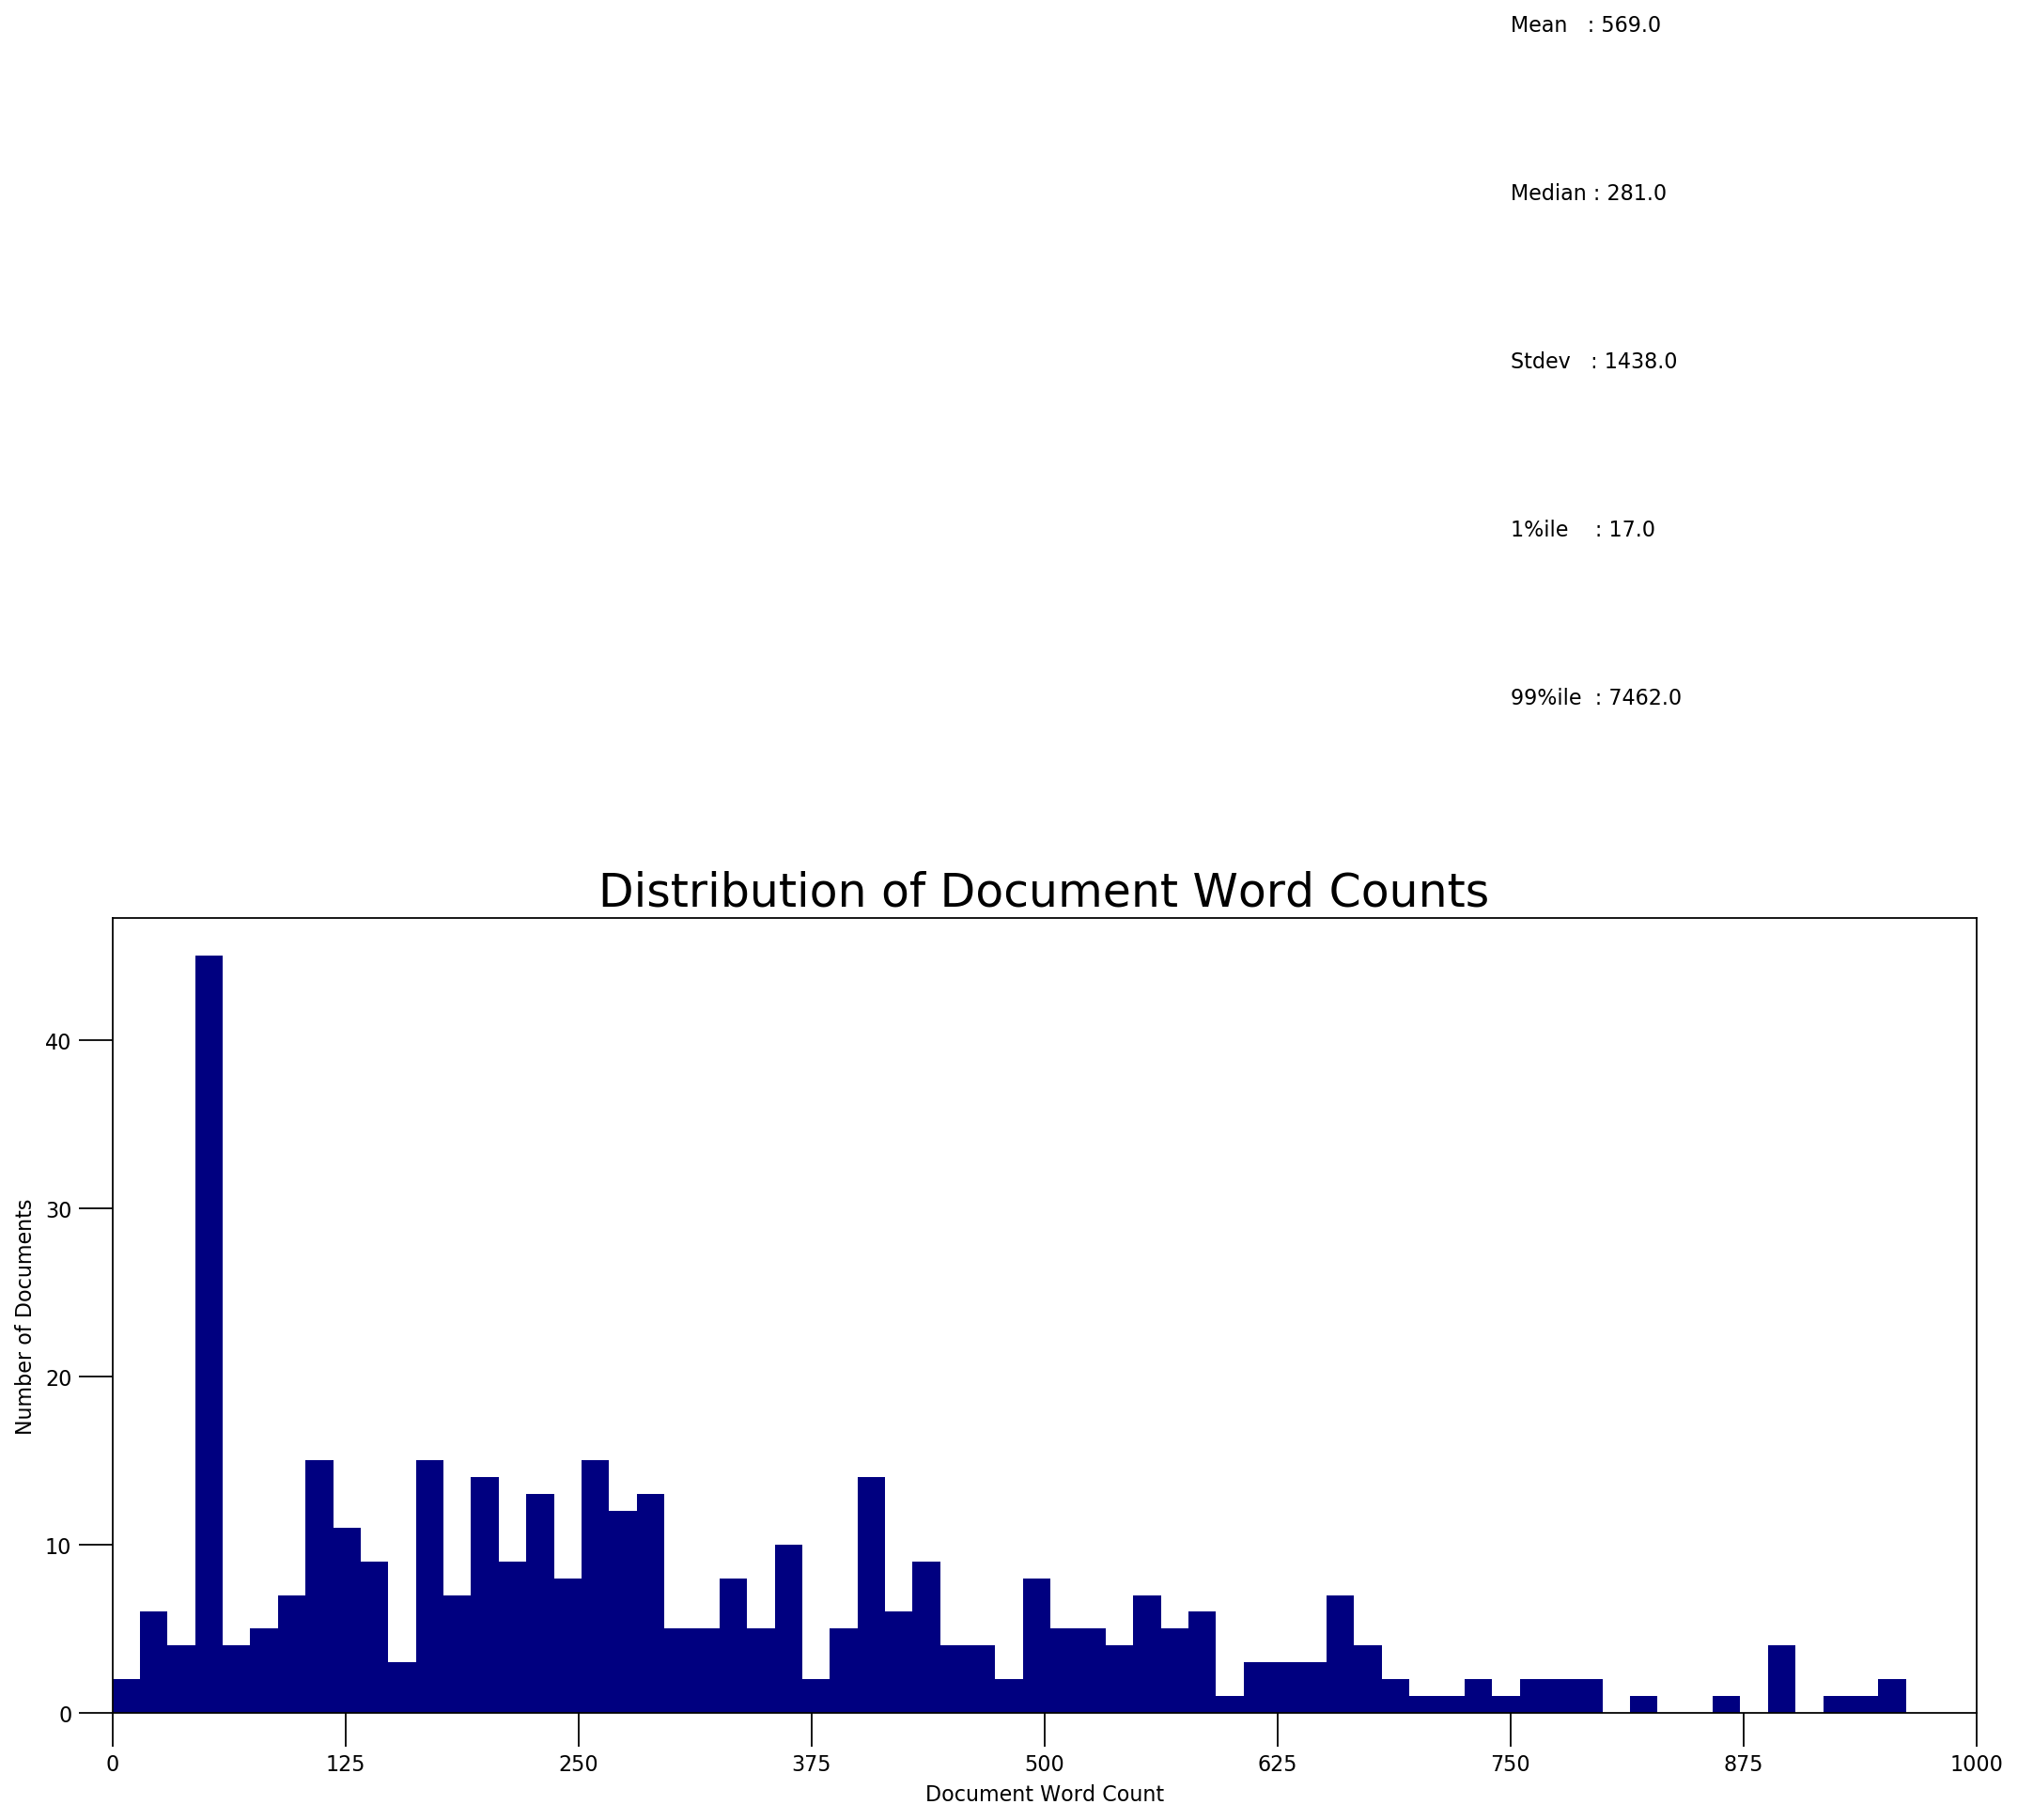

In [405]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

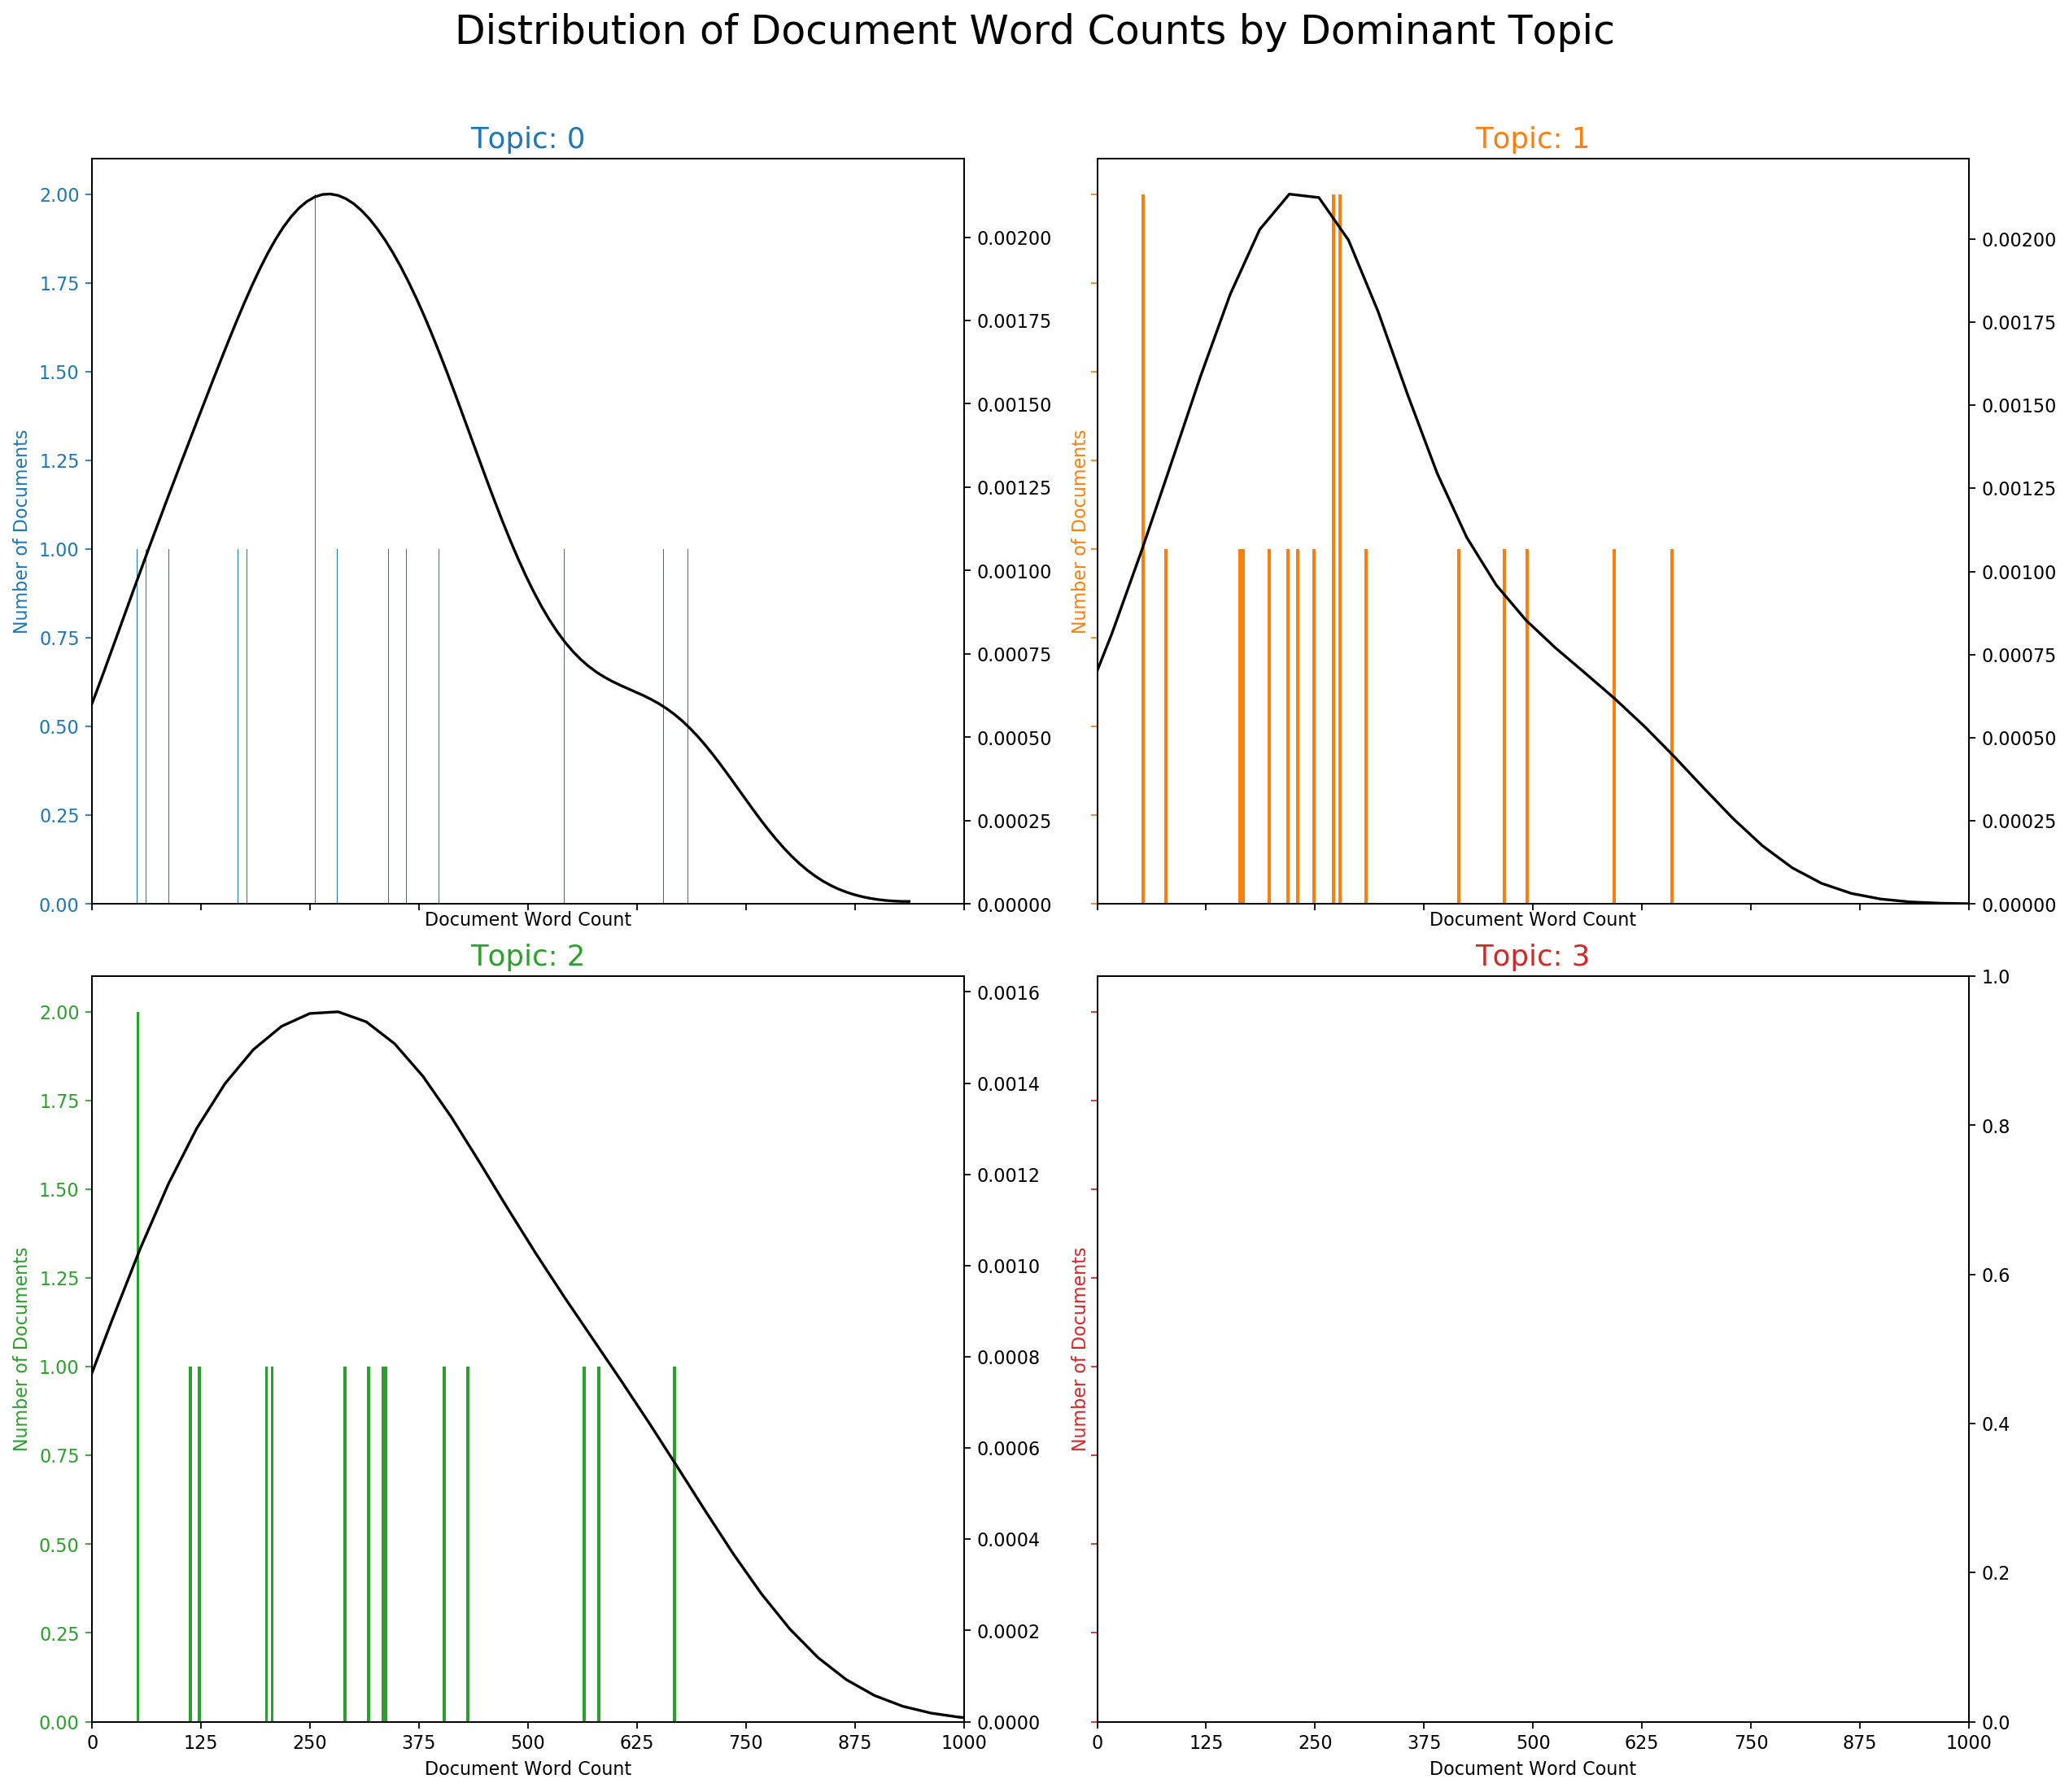

In [406]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

IndexError: list index out of range

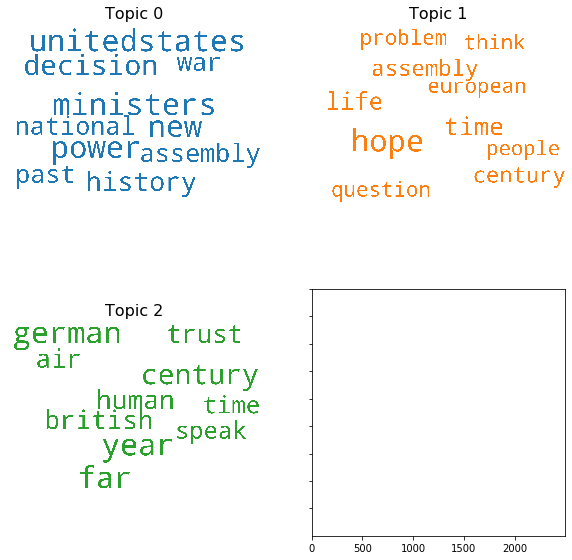

In [407]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()